In [1]:
!pip install pandas seaborn wordcloud tabulate
!ls


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
DataMiningProject.ipynb user_response_data.json video_data.json
user_data.json          venv


# Data Mining Project

## Topic: Deep Fake Detection

## Group Members (authors):
- **Shivin Agarwal**
    - Roll number: 231110048
    - Email: shivin23@iitk.ac.in
- **Sunil Kumar**
    - Roll number: 231110025
    - Email: sunilklc23@iitk.ac.in
- **Yuvraj Raghuvanshi**
    - Roll number: 241110084
    - Email: yuvrajpr24@iitk.ac.in

In [10]:
import math
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
from wordcloud import WordCloud
from tabulate import tabulate

pd.options.mode.chained_assignment = None


class DeepFakeDetection():
    def __init__(self):
        self.df_user = pd.read_json('user_data.json')
        self.df_video = pd.read_json('video_data.json') 
        self.user_responses = pd.read_json('user_response_data.json')
        self.response_ids_to_set_true = [9, 11, 12, 13, 16, 23, 20, 32, 33, 36, 39, 40, 48, 51, 34, 56]
        self.user_responses.loc[self.user_responses['response_id'].isin(self.response_ids_to_set_true), 'is_real'] = True
        
    def clean_responses(self):
        """
        Clean the Responses.
        """
        self.df_user = self.df_user[self.df_user['user_id'].isin(self.user_responses['user_id'])]        

    def avg_response_per_user(self):
        """
        Calculate average Response per user.
        """
        return math.ceil(self.user_responses.shape[0]/self.df_user.shape[0])

    def age_distinction(self):
        """
        Add Age Distinction.
        """
        bins = [20, 30, float('inf')]
        labels = ['20-29', '30+']
        # Add a new column 'age_range' to the users DataFrame with categorized age ranges
        self.df_user['age_range'] = pd.cut(self.df_user['age'], bins=bins, labels=labels, right=False)        

    def gender_distinction(self):
        """
        Update Gender of Participants.
        """
        email_to_gender = {
            'shivin.agarwal15@gmail.com': 'M',
            'yuvrajpr24@iitk.ac.in': 'M',
            'sunilklc23@iitk.ac.in': 'M',
            'aahimadhiman@gmail.com': 'F',
            'abhinav@gmail.com': 'M',
            'atulbose23@iitk.ac.in': 'M',
            'senthil@gmail.com': 'M',
            'manishr24@iitk.ac.in': 'M',
            'prathmesht24@iitk.ac.in': 'M',
            'keshav.banka2003@gmail.com': 'M',
            'tsewangn@iitk.ac.in': 'M',
            'jatinj24@iitk.ac.in': 'M',
            'asitbiswas24@iitk.ac.in': 'M',
            'dayalpushpam@gmail.com': 'M',
            'darshanj23@iitk.ac.in': 'M',
            'psharma23@iitk.ac.in': 'M',
            'himalayak24@iitk.ac.in': 'M',
            'govindsharma0402@gmail.com': 'M',
            'divyanshub20cse@gmail.com': 'M',
            'rakesh24@gmail.com': 'M',
            'vipulsangode@gmail.com': 'M',
            'jhadivyanshu99@gmail.com': 'M',
            'prashik.ganer123@gmail.com': 'M',
            'rizwan.ahmed7801@gmail.com': 'M',
            'madhavjha113@gmail.com': 'M',
            'gautamraazgr799@gmail.com': 'M',
            'c.07.mukundmadhav@gmail.com': 'M',
            'devang553@gmail.com': 'M',
            'Tushar@iitk.com': 'M',
            'anshulpurohit11@gmail.com': 'M',
            'tanyac23@iitk.ac.in': 'F',
            'saklanishanu@gmail.com': 'F',
            'Devangag554@gmail.com': 'M',
            'rubyprajapati632@gmail.com': 'F',
            'Priyans21@iitk.ac.in': 'M',
            '9161ashu2003@gmail.com': 'M',
            'kharsh21@iitk.ac.in': 'M',
            'prakhargurjar494@gmail.com': 'M',
            'Test@abc.com': 'M',
            '192pratibha@gmail.com': 'F',
            'himanshuk23@iitk.ac.in': 'M',
            'anilkumar23@iitk.ac.in': 'M',
            'tanmay@iitk.ac.in': 'M',
            'ravi@iitk.ac.in': 'M',
            'manishap@gmail.com': 'F',
            'sakshi@gmail.com': 'F',
            'neeluthegreat99@gmail.com': 'M',
            'neetus@iitk.ac.in': 'F',
            'ma331919@gmail.com': 'M'
        }
        self.df_user['gender'] = self.df_user['email'].map(email_to_gender)

    def number_of_videos(self):
        """
        Print Count of Videos.
        """
        real = self.df_video[self.df_video['is_real'] == True]
        fake = self.df_video[self.df_video['is_real'] == False]
        print(f'Total Number of Videos: {self.df_video.shape[0]}')
        print(f'Total Number of Real Videos: {real.shape[0]}')
        print(f'Total Number of Fake Videos: {fake.shape[0]}')

    def number_of_responses(self):
        """
        Calculate the number of Reponses.
        """
        return self.user_responses.shape[0]

    def confusion_matrix_metrics(self, df=pd.DataFrame):
        """
        TODO: Need to think more on this.
        """
        if df.empty:
            df = self.user_responses            

        df_merged = df.merge(self.df_video, on='video_id', how='left', suffixes=('_user', '_truth'))        
        y_true = df_merged['is_real_truth']  # Ground truth labels
        y_pred = df_merged['is_real_user']  # Predicted labels by model
        
        #Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[True,False])

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['User Response: Real', 'User Response: Fake'], yticklabels=['Actual: Real', 'Actual: Fake'], cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('User Response')
        plt.ylabel('Source of Truth')
        plt.show()

        TP = cm[0, 0]
        TN = cm[1, 1]
        FP = cm[1, 0]
        FN = cm[0, 1]        
        
        # Calculate the metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        precision_fake = TN / ( TN + FN) if ( TN + FN) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0        
        tnr = TN / (TN + FP) if (TN + FP) != 0 else 0  # True Negative Rate (Specificity)
        fpr = FP / (TN + FP) if (TN + FP) != 0 else 0  # False Positive Rate
        fnr = FN / (TP + FN) if (TP + FN) != 0 else 0  # False Negative Rate
        error_rate = (FP + FN) / (TP + TN + FP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
        # Store metrics in a dictionary for easy plotting
        metrics = {
            'Accuracy': accuracy,
            'Precision (REAL)': precision,
            'True Negative Accuracy (FAKE)': precision_fake,
            'Recall': recall,
            'True Negative Rate ( Recall Fake)': tnr,
            'False Positive Rate': fpr,
            'False Negative Rate': fnr,
            'Error Rate': error_rate,
            'F1 Score': f1_score
        }

        metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
        # Print the DataFrame
        print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))
        
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for random guessing
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        average_precision = average_precision_score(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='purple', label=f"Precision-Recall Curve (AP = {average_precision:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.show()

    def tf_df_show(self):        
        # Separate user responses based on 'is_real' (user's perception)
        real_responses = self.user_responses[self.user_responses['is_real'] == True]['reason']
        fake_responses = self.user_responses[self.user_responses['is_real'] == False]['reason']
        
        # Initialize TF-IDF Vectorizer        
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=30)
        
        # Calculate TF-IDF for 'real' responses
        real_tfidf_matrix = tfidf_vectorizer.fit_transform(real_responses)
        real_feature_names = tfidf_vectorizer.get_feature_names_out()
        real_tfidf_scores = real_tfidf_matrix.sum(axis=0).A1
        real_tfidf_df = pd.DataFrame({'word': real_feature_names, 'tfidf_score': real_tfidf_scores})
        
        # Calculate TF-IDF for 'fake' responses
        fake_tfidf_matrix = tfidf_vectorizer.fit_transform(fake_responses)
        fake_feature_names = tfidf_vectorizer.get_feature_names_out()
        fake_tfidf_scores = fake_tfidf_matrix.sum(axis=0).A1
        fake_tfidf_df = pd.DataFrame({'word': fake_feature_names, 'tfidf_score': fake_tfidf_scores})
        
        # Find common words
        common_words = set(real_tfidf_df['word']).intersection(set(fake_tfidf_df['word']))
        
        # Filter out common words in each DataFrame
        real_unique_df = real_tfidf_df[~real_tfidf_df['word'].isin(common_words)].sort_values(by='tfidf_score', ascending=False)
        fake_unique_df = fake_tfidf_df[~fake_tfidf_df['word'].isin(common_words)].sort_values(by='tfidf_score', ascending=False)
        
        # Plotting the unique top words for 'real' responses
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.barplot(x='tfidf_score', y='word', data=real_unique_df.head(15), palette='Blues_d')
        plt.title("Unique Top Words (User Marked as Real)")
        plt.xlabel("TF-IDF Score")
        plt.ylabel("Word")
        
        # Plotting the unique top words for 'fake' responses
        plt.subplot(1, 2, 2)
        sns.barplot(x='tfidf_score', y='word', data=fake_unique_df.head(15), palette='Reds_d')
        plt.title("Unique Top Words (User Marked as Fake)")
        plt.xlabel("TF-IDF Score")
        plt.ylabel("Word")
        
        plt.tight_layout()
        plt.show()
        

    def temporal_analysis(self):
        # Merge user responses with video ground truth data
        merged_df = self.user_responses.merge(self.df_video[['video_id', 'is_real']], on='video_id', how='left', suffixes=('_user', '_ground_truth'))
        
        # Sort the responses by time for each user
        merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], unit='ms')  # Convert timestamp to datetime
        merged_df = merged_df.sort_values(by=['user_id', 'created_at'])
        
        # Calculate accuracy for each response
        merged_df['accuracy'] = merged_df['is_real_user'] == merged_df['is_real_ground_truth']
        
        # Group by user_id and calculate cumulative accuracy over time
        merged_df['cumulative_accuracy'] = merged_df.groupby('user_id')['accuracy'].cumsum() / (merged_df.groupby('user_id').cumcount() + 1)
        
        
        # Plot cumulative accuracy for the user with most reponses
        sample_user_df = merged_df[merged_df['user_id'] == 47]
        
        # Convert timestamp to datetime and sort by user and time
        merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], unit='ms')
        merged_df = merged_df.sort_values(by=['user_id', 'created_at'])
        
        # Calculate accuracy for each response
        merged_df['accuracy'] = merged_df['is_real_user'] == merged_df['is_real_ground_truth']
        
        # Filter out users who didn’t respond at all
        response_counts = merged_df.groupby('user_id').size()
        active_users = response_counts[response_counts > 15].index
        
        # Calculate the accuracy for each active user
        user_accuracy = merged_df[merged_df['user_id'].isin(active_users)].groupby('user_id')['accuracy'].mean()
        
        # Identify best and worst performers
        best_performer_id = user_accuracy.idxmax()
        worst_performer_id = user_accuracy.idxmin()
        
        # Calculate cumulative accuracy for each response over time
        merged_df['cumulative_accuracy'] = merged_df.groupby('user_id')['accuracy'].cumsum() / (merged_df.groupby('user_id').cumcount() + 1)
        
        # Plot cumulative accuracy over time for the best performer
        best_user_df = merged_df[merged_df['user_id'] == best_performer_id]
        plt.figure(figsize=(10, 6))
        plt.plot(best_user_df['created_at'], best_user_df['cumulative_accuracy'], label='Cumulative Accuracy (Best Performer)', color='green')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Accuracy')
        plt.title(f'Cumulative Accuracy Over Time for Best Performer (User ID {best_performer_id}) and total reviews {self.user_responses[self.user_responses["user_id"]==best_performer_id].shape[0]}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.show()
        
        # Plot cumulative accuracy over time for the worst performer
        worst_user_df = merged_df[merged_df['user_id'] == worst_performer_id]
        plt.figure(figsize=(10, 6))
        plt.plot(worst_user_df['created_at'], worst_user_df['cumulative_accuracy'], label='Cumulative Accuracy (Worst Performer)', color='red')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Accuracy')
        plt.title(f'Cumulative Accuracy Over Time for Worst Performer (User ID {worst_performer_id}) and total reviews {self.user_responses[self.user_responses["user_id"]==worst_performer_id].shape[0]}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(sample_user_df['created_at'], sample_user_df['cumulative_accuracy'], label='Cumulative Accuracy')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Accuracy')
        plt.title(f'Cumulative Accuracy Over Time for User id 47 and total reviews {sample_user_df.shape[0]}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
        
        # For all users, plot average accuracy over time
        plt.figure(figsize=(10, 6))
        avg_accuracy = merged_df.groupby('created_at')['accuracy'].mean()
        plt.plot(avg_accuracy.index, avg_accuracy, label='Average Accuracy Over Time')
        plt.xlabel('Time')
        plt.ylabel('Average Accuracy')
        plt.title('Average Accuracy Over Time (All Users)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    
    def lda_topic_modeling(self, feedback, n_topics=5, n_words=10):
        vectorizer = CountVectorizer(stop_words='english', max_features=1000)  # Adjust max_features as needed
        feedback_matrix = vectorizer.fit_transform(feedback)
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(feedback_matrix)
    
        feature_names = vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda.components_):
            print(f"Topic {topic_idx + 1}:")
            print(" | ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
            
    def lda(self):
        # Execute LDA to discover topics
        # Extract the 'reason' column
        feedback = self.user_responses['reason'].fillna('')  # Fill NaN with empty strings
        self.lda_topic_modeling(feedback, n_topics=5, n_words=10)

    def preprocess_text(self, text):
        text = text.lower().translate(str.maketrans('', '', string.punctuation))
        return text

    def world_cloud_clean(self, df):
        """
        """
        df.loc[:, 'cleaned_reason'] = df['reason'].apply(self.preprocess_text)
        custom_stopword = ['is', 'the', 'if', 'and']
        word_counts = Counter()
        for reason in df['cleaned_reason']:
            word_counts.update([i for i in reason.split() if i not in custom_stopword])
        
        word_count_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    def world_cloud(self, df):
        """
        """
        df.loc[:, 'cleaned_reason'] = df['reason'].apply(self.preprocess_text) 
        word_counts = Counter()
        for reason in df['cleaned_reason']:
            r = reason.split()
            word_counts.update(r)
        
        word_count_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    def world_cloud_ind(self, df):
        """
        """
        df = df.merge(self.df_video, on='video_id', how='left', suffixes=('_user', '_truth'))
        df = df[df['is_real_user'] == df['is_real_truth']]
        df.loc[:, 'cleaned_reason'] = df['reason'].apply(self.preprocess_text)
        word_counts = Counter()
        for reason in df['cleaned_reason']:
            r = reason.split()
            word_counts.update(r)
        
        word_count_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

---

# Cleaning and Preprocessing Data

In [11]:
dfd = DeepFakeDetection()
# Cleaning data
dfd.clean_responses()
dfd.age_distinction()
dfd.gender_distinction()

---

# Basic Details

In [4]:
dfd.number_of_videos()
print("------------------------------")
print(f"Number of reviews: {dfd.number_of_responses()}")
print("------------------------------")
print(f"Number of Participants: {dfd.df_user.shape[0]}")
print("------------------------------")
print(f"Average Response per user: {dfd.avg_response_per_user()}")
print("------------------------------")
# User background details. Age Group, Gender, Branch and Dept.
user = dfd.df_user
age_groups = user.groupby('age_range', observed=True)
for age, age_group in age_groups:
    if age_group.shape[0] > 0:
        print(f'Age: {age}, Total Participants {age_group.shape[0]}')
print('\n')
genders = user.groupby('gender', observed=True)
for gender, gender_group in genders:
    print(f'Gender: {gender}, Total Participants {gender_group.shape[0]}')
print('\n')
banches = user.groupby('branch', observed=True)
for branch, branch_group in banches:
    print(f'Branch: {branch}, Total Participants {branch_group.shape[0]}')
print('\n')
depts = user.groupby('department', observed=True)
for department, department_group in depts:
    print(f'Department: {department}, Total Participants {department_group.shape[0]}')
print('\n')

Total Number of Videos: 600
Total Number of Real Videos: 200
Total Number of Fake Videos: 400
------------------------------
Number of reviews: 1420
------------------------------
Number of Participants: 48
------------------------------
Average Response per user: 30
------------------------------
Age: 20-24, Total Participants 28
Age: 25-29, Total Participants 10
Age: 30-34, Total Participants 6
Age: 35-39, Total Participants 2
Age: 40+, Total Participants 2


Gender: F, Total Participants 7
Gender: M, Total Participants 39


Branch: B.Tech, Total Participants 5
Branch: M.Sc. (2 yr), Total Participants 1
Branch: M.Tech, Total Participants 35
Branch: Others, Total Participants 3
Branch: Ph.D, Total Participants 4


Department: Cognitive Science, Total Participants 1
Department: Computer Science and Engineering, Total Participants 33
Department: Electrical Engineering, Total Participants 1
Department: Materials Science Programme, Total Participants 1
Department: Materials Science and En

---

# Accuracy and Consistency Analysis

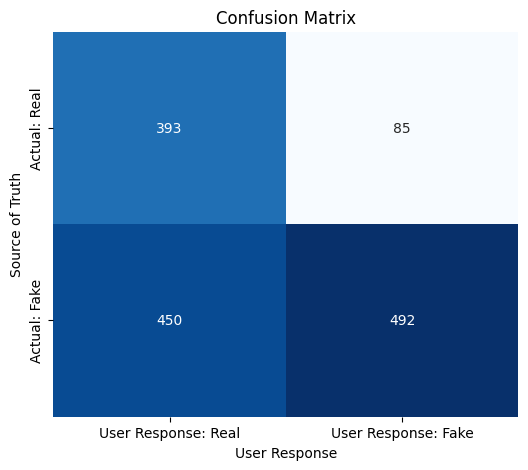

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6232394366197183  |
| 1 |         Precision (REAL)          | 0.46619217081850534 |
| 2 |   True Negative Accuracy (FAKE)   | 0.8526863084922011  |
| 3 |              Recall               | 0.8221757322175732  |
| 4 | True Negative Rate ( Recall Fake) | 0.5222929936305732  |
| 5 |        False Positive Rate        | 0.47770700636942676 |
| 6 |        False Negative Rate        | 0.17782426778242677 |
| 7 |            Error Rate             | 0.3767605633802817  |
| 8 |             F1 Score              |  0.595003785011355  |
+---+-----------------------------------+---------------------+


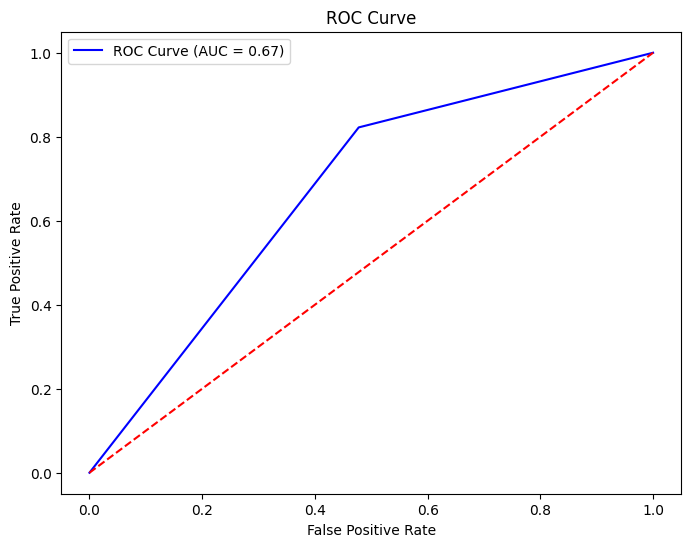

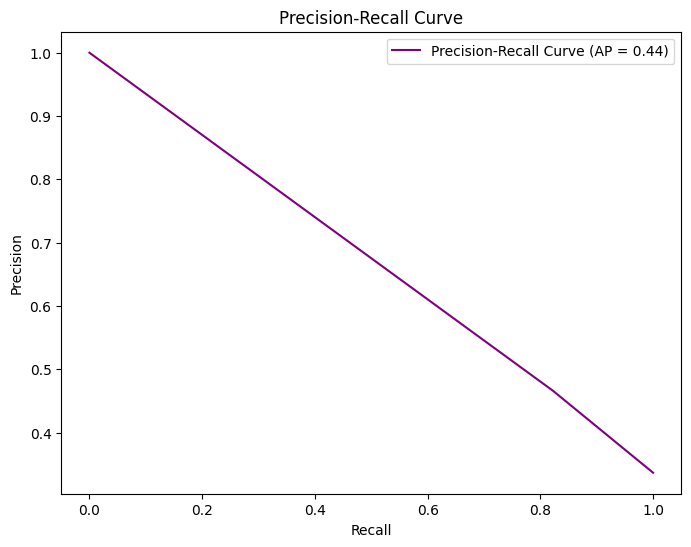

In [5]:
dfd.confusion_matrix_metrics()

---

# Word Cloud Over All Data

## Review of Real Videos

With common Stop Word


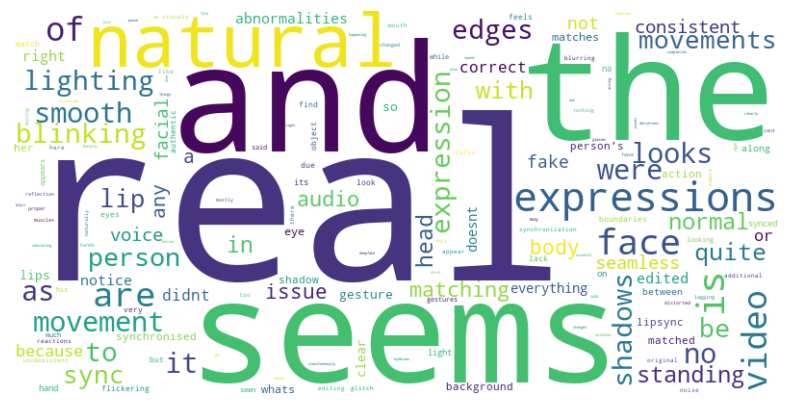

Without common Stop Words


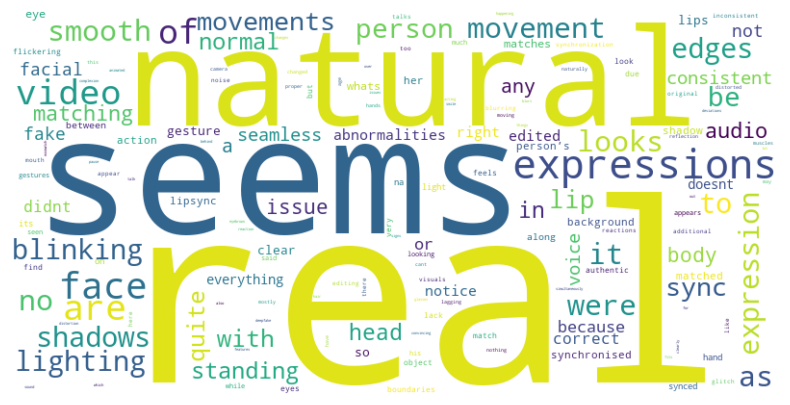

For Correct Responses


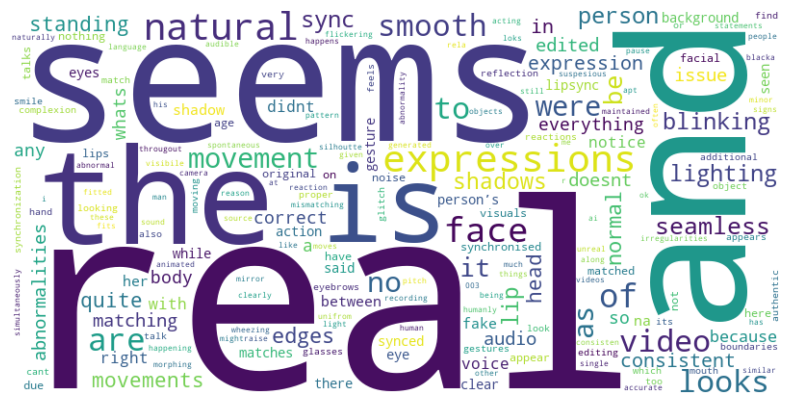

In [6]:
df_real = dfd.user_responses[dfd.user_responses['is_real'] == True]
print("\033[1mWith common Stop Word")
dfd.world_cloud(df_real)
print("\033[1mWithout common Stop Words")
dfd.world_cloud_clean(df_real)
print("\033[1mFor Correct Responses")
dfd.world_cloud_ind(df_real)


---

## Review of Fake Videos

With common Stop Word


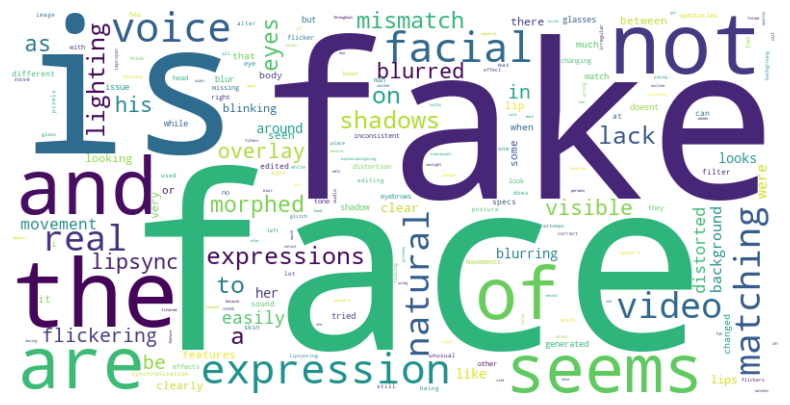

Without common Stop Words


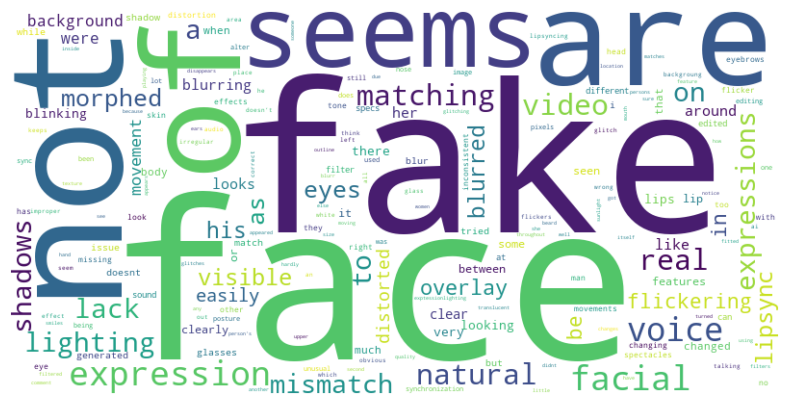

For Correct Responses


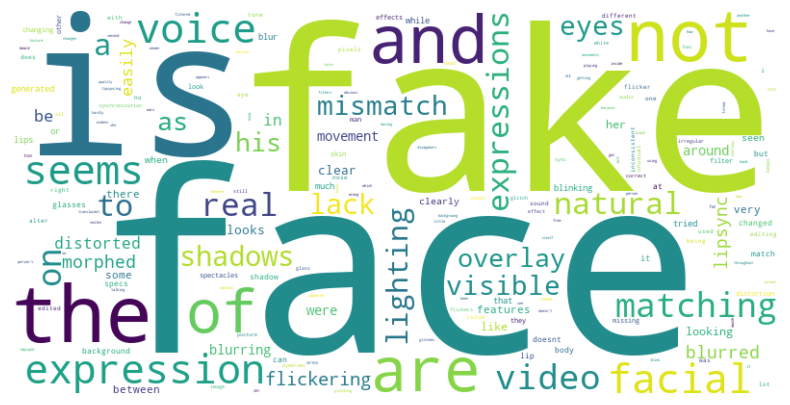

In [7]:
df_false = dfd.user_responses[dfd.user_responses['is_real'] == False]
print("\033[1mWith common Stop Word")
dfd.world_cloud(df_false)
print("\033[1mWithout common Stop Words")
dfd.world_cloud_clean(df_false)
print("\033[1mFor Correct Responses")
dfd.world_cloud_ind(df_false)

---

# Temporal Analysis

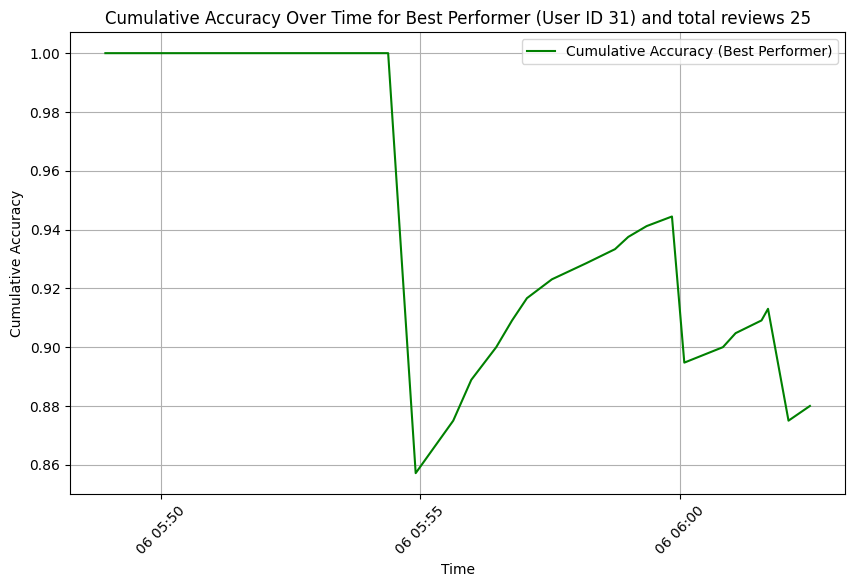

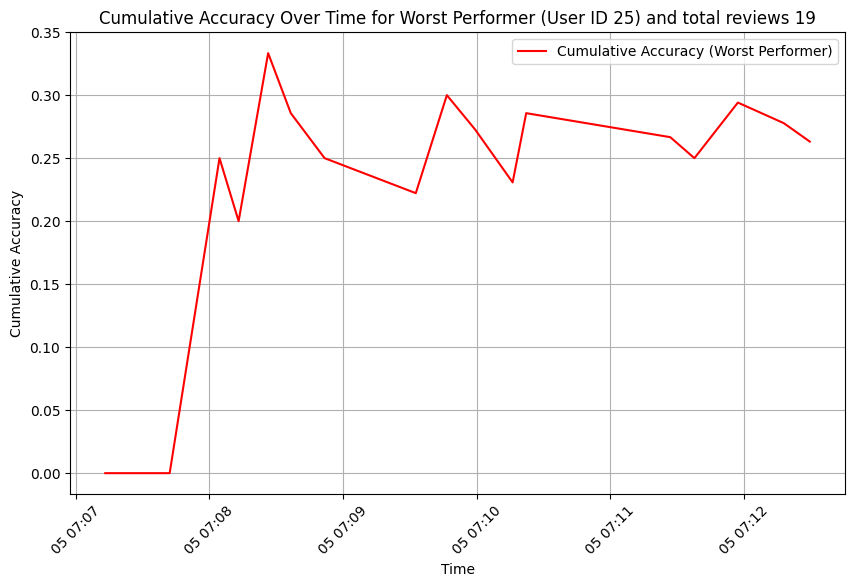

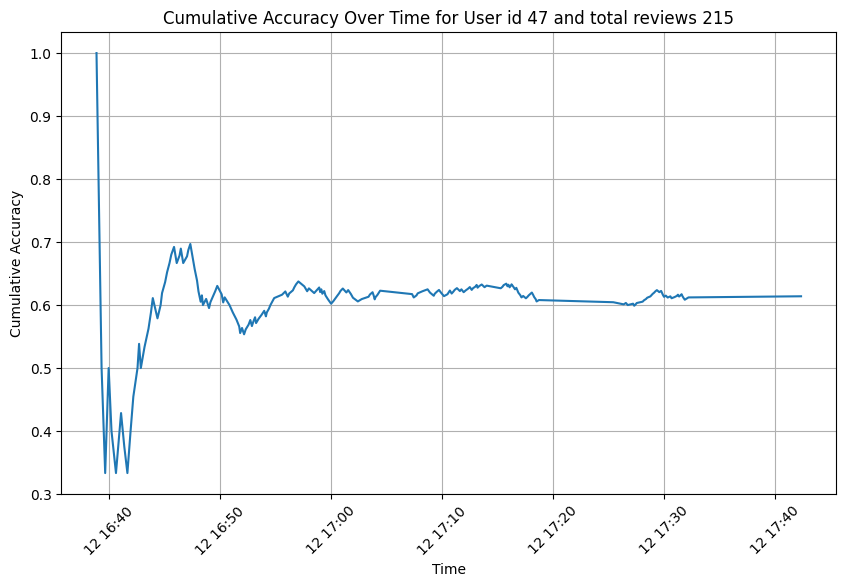

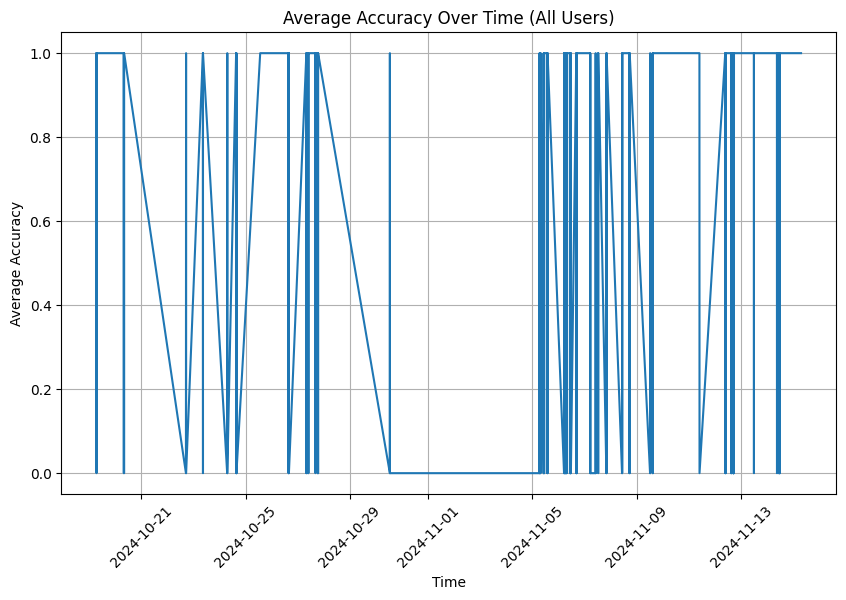

In [8]:
dfd.temporal_analysis()

---

# Demographic Analysis

## Gender Wise

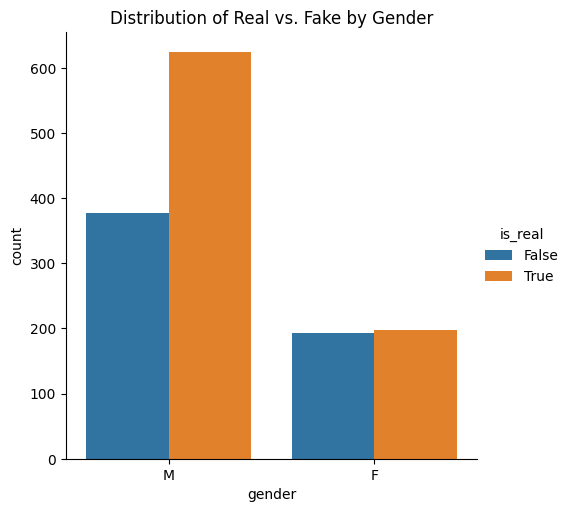

In [9]:
df = dfd.user_responses.merge(dfd.df_user, on='user_id', how='left', suffixes=('_response', '_user'))
sns.catplot(data=df, x="gender", hue="is_real", kind="count")
plt.title("Distribution of Real vs. Fake by Gender")
plt.show()

---

### Male

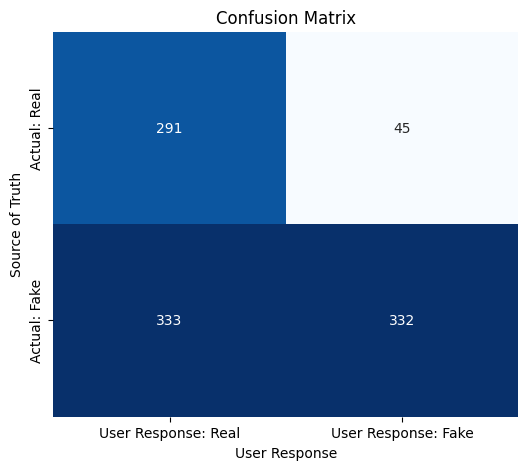

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6223776223776224  |
| 1 |         Precision (REAL)          | 0.46634615384615385 |
| 2 |   True Negative Accuracy (FAKE)   | 0.8806366047745358  |
| 3 |              Recall               | 0.8660714285714286  |
| 4 | True Negative Rate ( Recall Fake) | 0.4992481203007519  |
| 5 |        False Positive Rate        | 0.5007518796992482  |
| 6 |        False Negative Rate        | 0.13392857142857142 |
| 7 |            Error Rate             | 0.3776223776223776  |
| 8 |             F1 Score              |       0.60625       |
+---+-----------------------------------+---------------------+


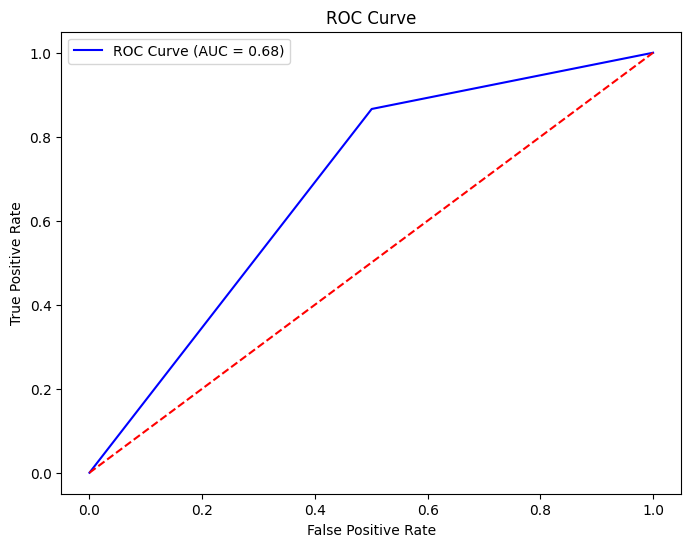

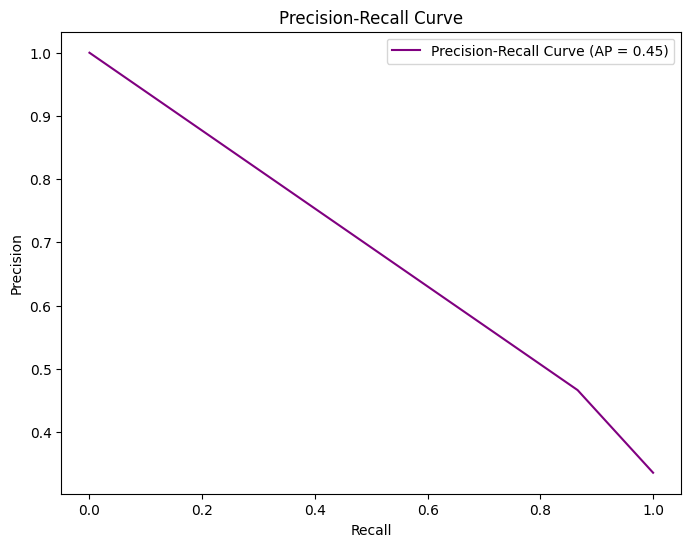

In [10]:
male_df = dfd.df_user[dfd.df_user['gender'] == 'M']
responses = dfd.user_responses[dfd.user_responses['user_id'].isin(male_df['user_id'])]
plt.show()
dfd.confusion_matrix_metrics(responses)

### Female

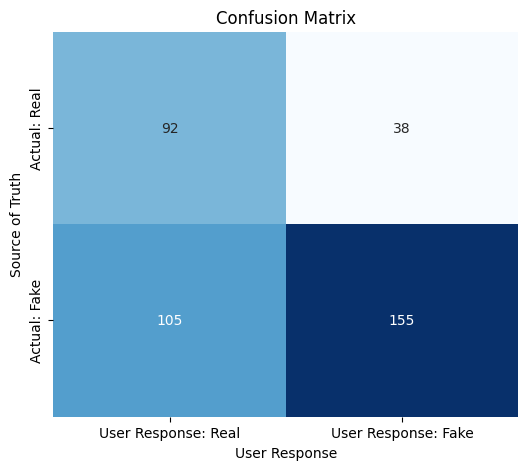

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6333333333333333  |
| 1 |         Precision (REAL)          |  0.467005076142132  |
| 2 |   True Negative Accuracy (FAKE)   | 0.8031088082901554  |
| 3 |              Recall               | 0.7076923076923077  |
| 4 | True Negative Rate ( Recall Fake) | 0.5961538461538461  |
| 5 |        False Positive Rate        | 0.40384615384615385 |
| 6 |        False Negative Rate        | 0.2923076923076923  |
| 7 |            Error Rate             | 0.36666666666666664 |
| 8 |             F1 Score              | 0.5626911314984709  |
+---+-----------------------------------+---------------------+


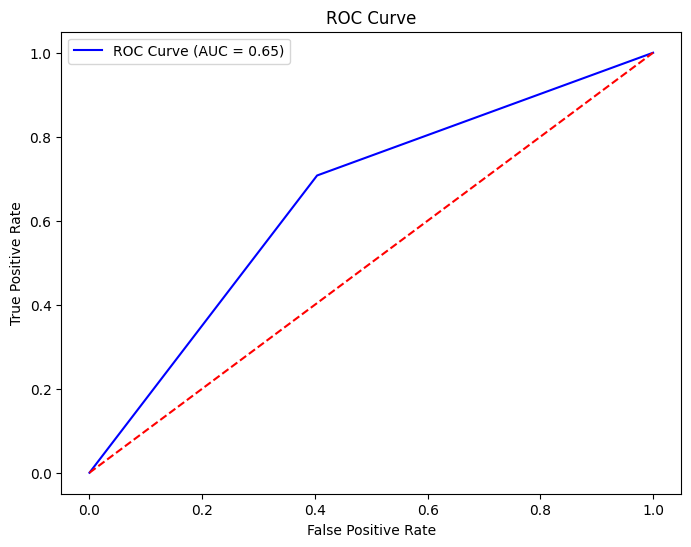

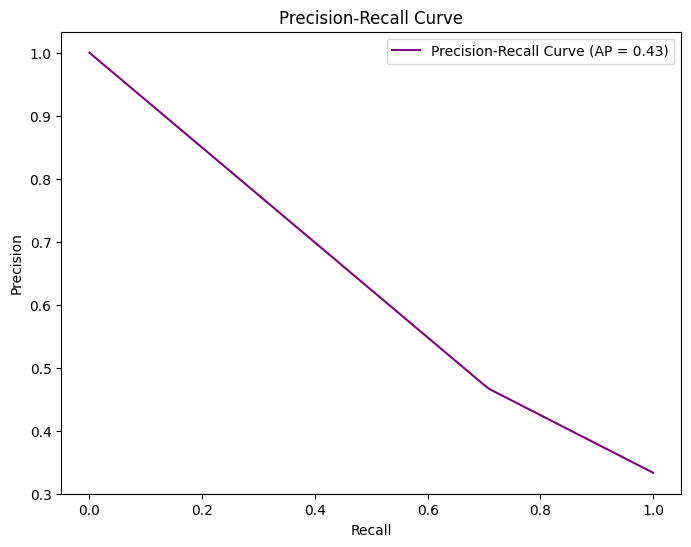

In [11]:
female_df = dfd.df_user[dfd.df_user['gender'] == 'F']
responses = dfd.user_responses[dfd.user_responses['user_id'].isin(female_df['user_id'])]
dfd.confusion_matrix_metrics(responses)

---

## Branch Wise

For branch B.Tech



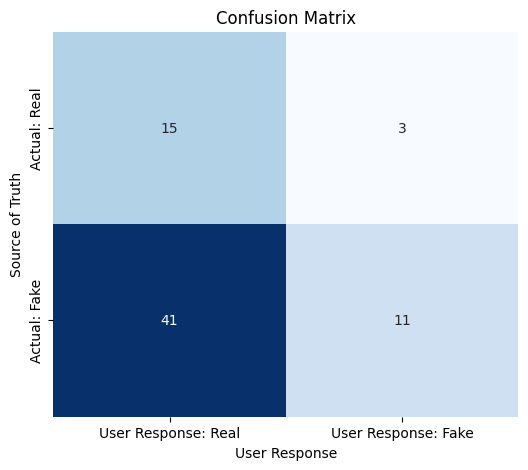

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.37142857142857144 |
| 1 |         Precision (REAL)          | 0.26785714285714285 |
| 2 |   True Negative Accuracy (FAKE)   | 0.7857142857142857  |
| 3 |              Recall               | 0.8333333333333334  |
| 4 | True Negative Rate ( Recall Fake) | 0.21153846153846154 |
| 5 |        False Positive Rate        | 0.7884615384615384  |
| 6 |        False Negative Rate        | 0.16666666666666666 |
| 7 |            Error Rate             | 0.6285714285714286  |
| 8 |             F1 Score              | 0.4054054054054054  |
+---+-----------------------------------+---------------------+


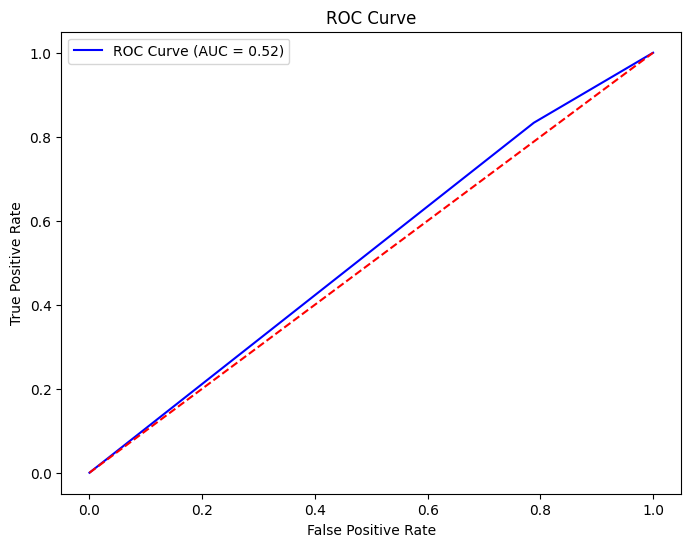

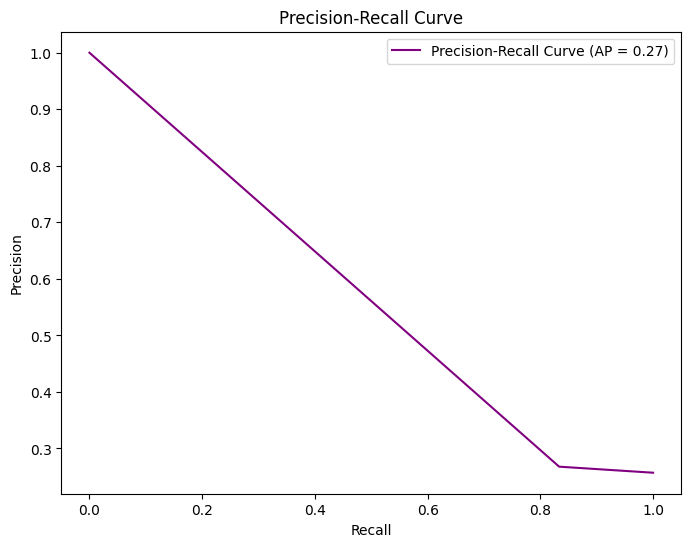

For branch M.Sc. (2 yr)



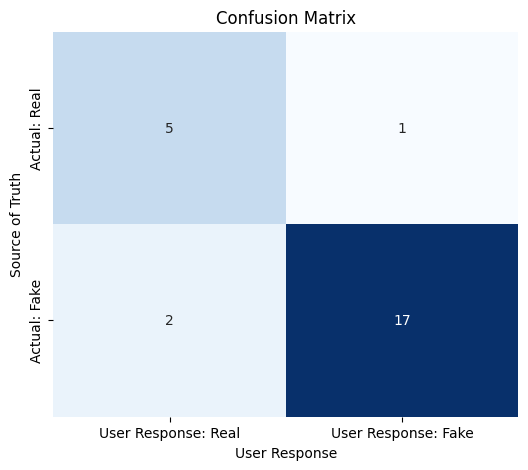

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              |        0.88         |
| 1 |         Precision (REAL)          | 0.7142857142857143  |
| 2 |   True Negative Accuracy (FAKE)   | 0.9444444444444444  |
| 3 |              Recall               | 0.8333333333333334  |
| 4 | True Negative Rate ( Recall Fake) | 0.8947368421052632  |
| 5 |        False Positive Rate        | 0.10526315789473684 |
| 6 |        False Negative Rate        | 0.16666666666666666 |
| 7 |            Error Rate             |        0.12         |
| 8 |             F1 Score              | 0.7692307692307692  |
+---+-----------------------------------+---------------------+


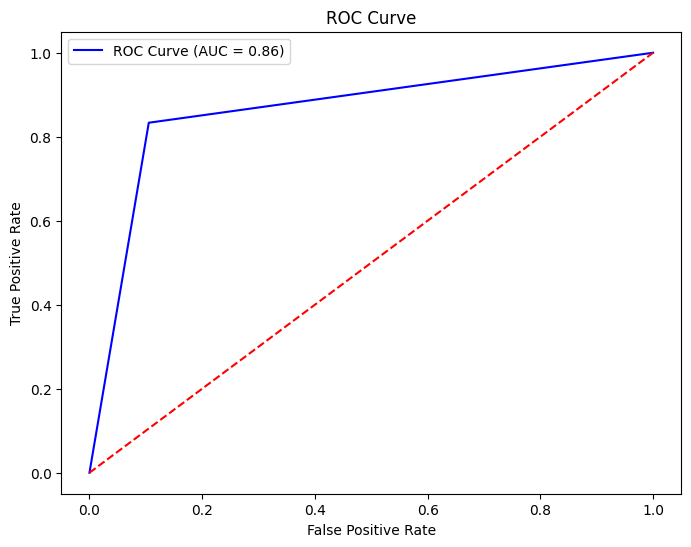

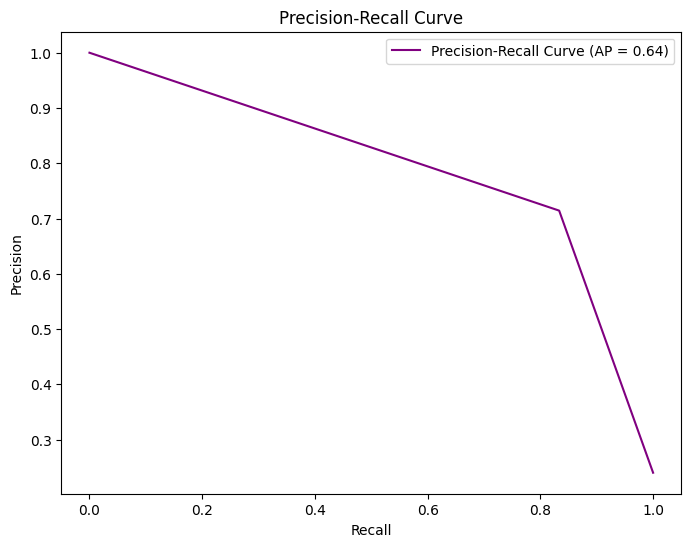

For branch M.Tech



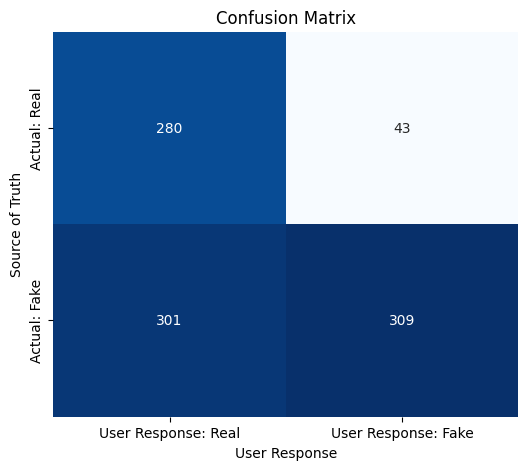

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6312968917470525  |
| 1 |         Precision (REAL)          | 0.4819277108433735  |
| 2 |   True Negative Accuracy (FAKE)   | 0.8778409090909091  |
| 3 |              Recall               | 0.8668730650154799  |
| 4 | True Negative Rate ( Recall Fake) | 0.5065573770491804  |
| 5 |        False Positive Rate        | 0.4934426229508197  |
| 6 |        False Negative Rate        | 0.13312693498452013 |
| 7 |            Error Rate             | 0.3687031082529475  |
| 8 |             F1 Score              | 0.6194690265486726  |
+---+-----------------------------------+---------------------+


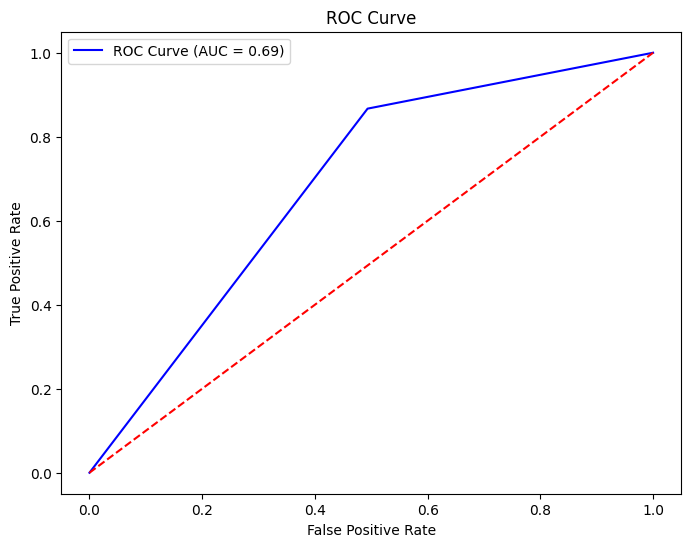

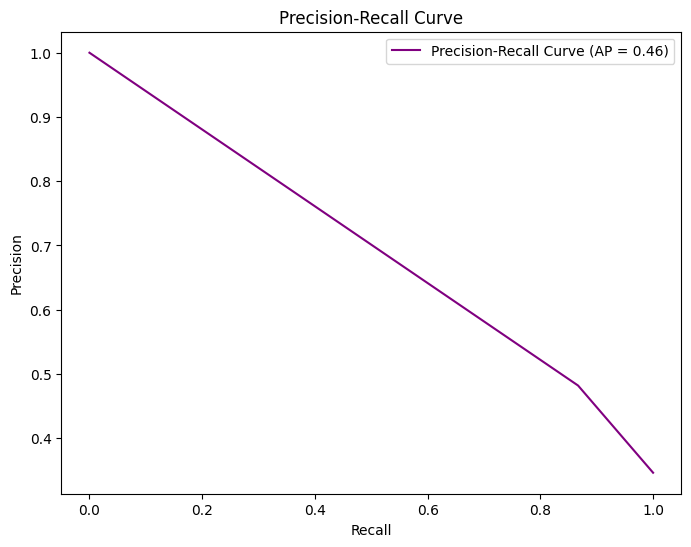

For branch Others



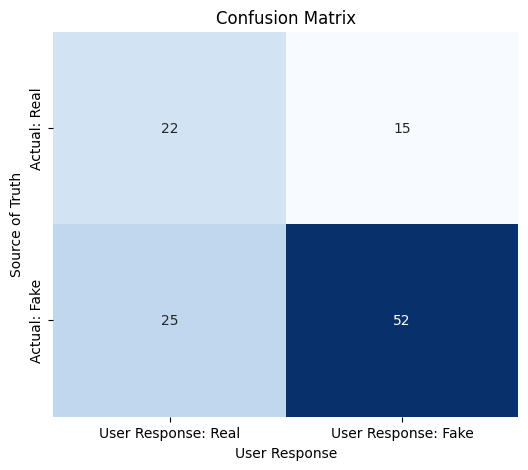

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6491228070175439  |
| 1 |         Precision (REAL)          | 0.46808510638297873 |
| 2 |   True Negative Accuracy (FAKE)   | 0.7761194029850746  |
| 3 |              Recall               | 0.5945945945945946  |
| 4 | True Negative Rate ( Recall Fake) | 0.6753246753246753  |
| 5 |        False Positive Rate        | 0.3246753246753247  |
| 6 |        False Negative Rate        | 0.40540540540540543 |
| 7 |            Error Rate             | 0.3508771929824561  |
| 8 |             F1 Score              | 0.5238095238095238  |
+---+-----------------------------------+---------------------+


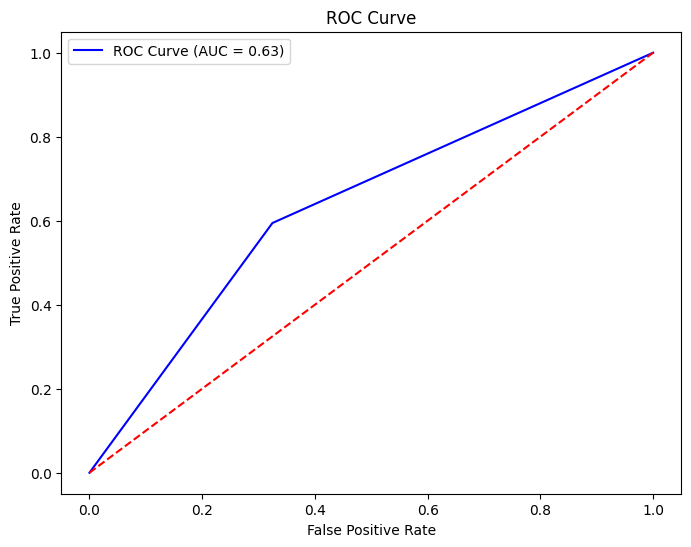

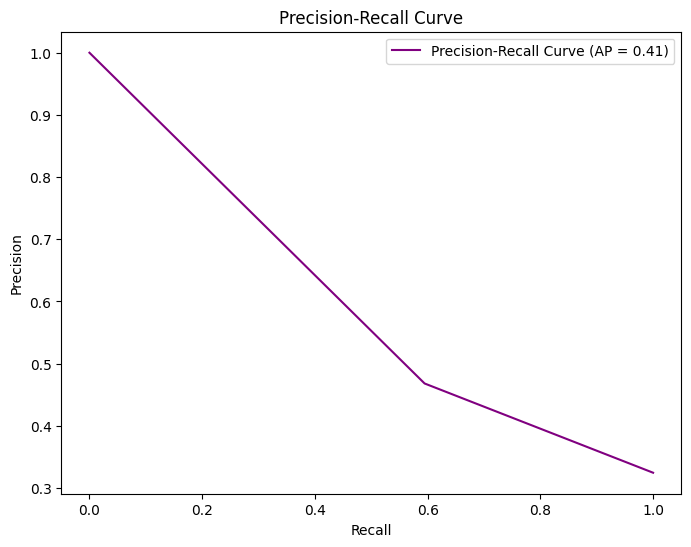

For branch Ph.D



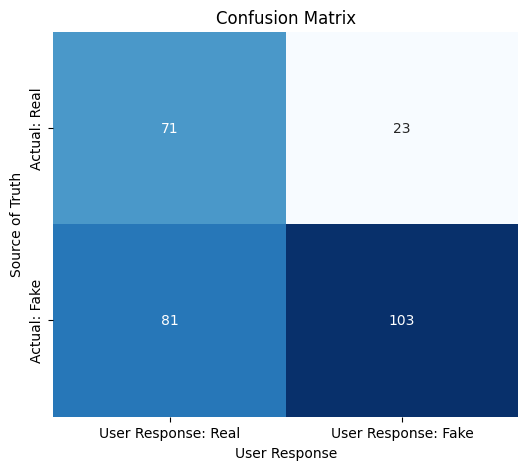

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6258992805755396  |
| 1 |         Precision (REAL)          | 0.46710526315789475 |
| 2 |   True Negative Accuracy (FAKE)   | 0.8174603174603174  |
| 3 |              Recall               | 0.7553191489361702  |
| 4 | True Negative Rate ( Recall Fake) | 0.5597826086956522  |
| 5 |        False Positive Rate        | 0.44021739130434784 |
| 6 |        False Negative Rate        | 0.24468085106382978 |
| 7 |            Error Rate             | 0.37410071942446044 |
| 8 |             F1 Score              | 0.5772357723577236  |
+---+-----------------------------------+---------------------+


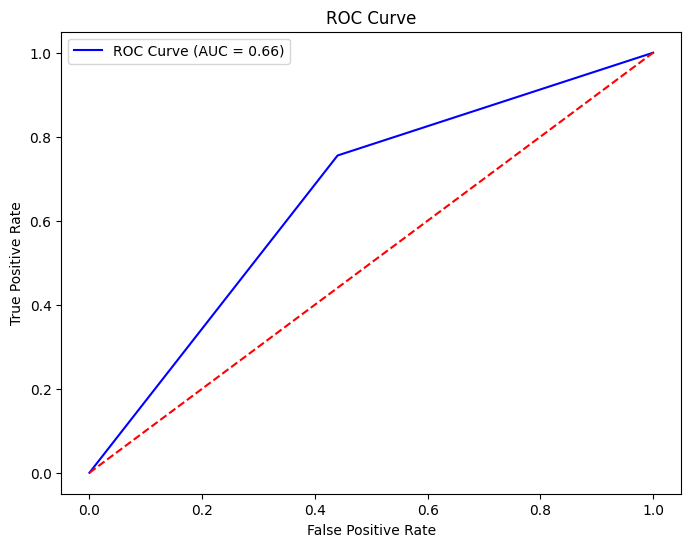

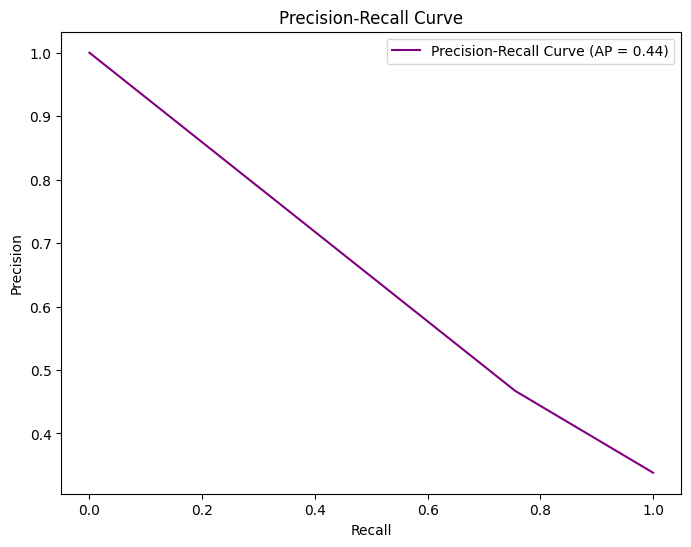

In [6]:
df_branch = dfd.df_user.groupby('branch')
for i, j in df_branch:
    print(f'For branch {i}\n')        
    responses = dfd.user_responses[dfd.user_responses['user_id'].isin(j['user_id'])]
    dfd.confusion_matrix_metrics(responses)

---

## Department Wise

For branch Cognitive Science



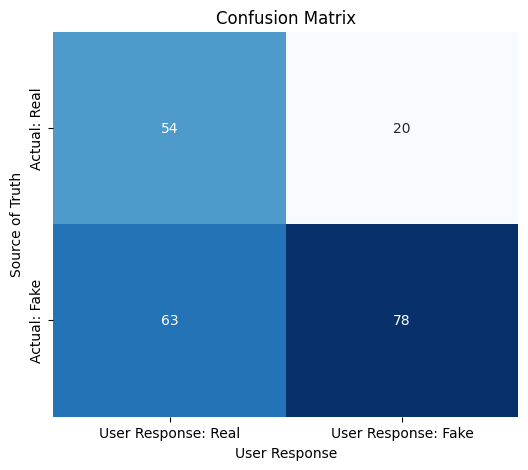

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6139534883720931  |
| 1 |         Precision (REAL)          | 0.46153846153846156 |
| 2 |   True Negative Accuracy (FAKE)   | 0.7959183673469388  |
| 3 |              Recall               | 0.7297297297297297  |
| 4 | True Negative Rate ( Recall Fake) | 0.5531914893617021  |
| 5 |        False Positive Rate        | 0.44680851063829785 |
| 6 |        False Negative Rate        | 0.2702702702702703  |
| 7 |            Error Rate             |  0.386046511627907  |
| 8 |             F1 Score              | 0.5654450261780105  |
+---+-----------------------------------+---------------------+


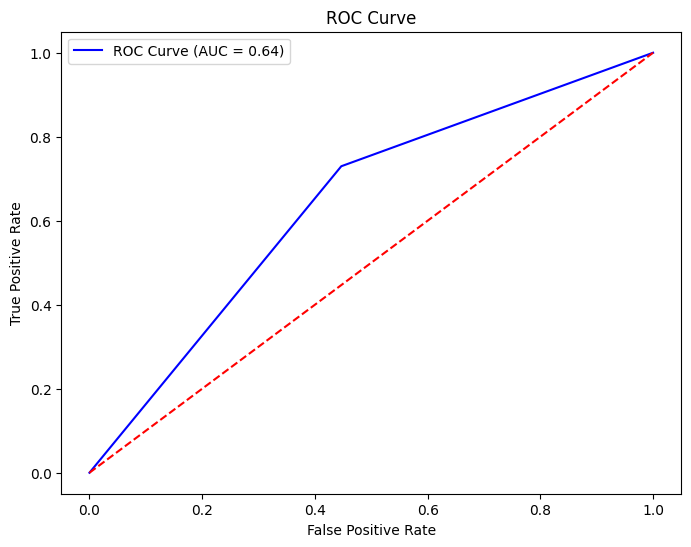

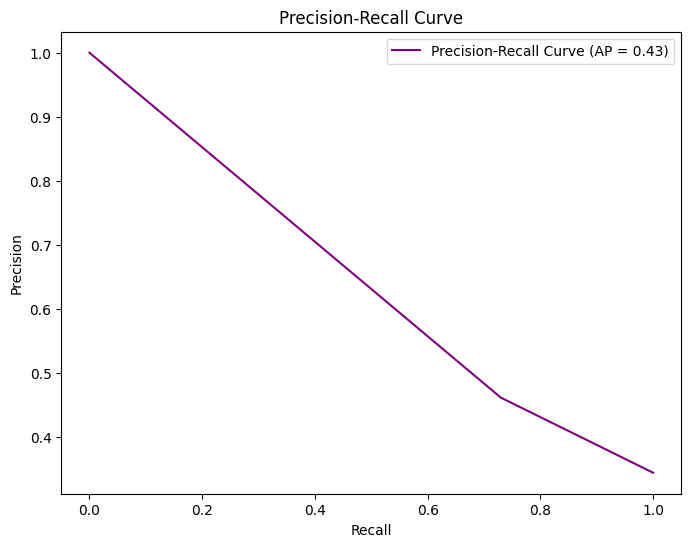

For branch Computer Science and Engineering



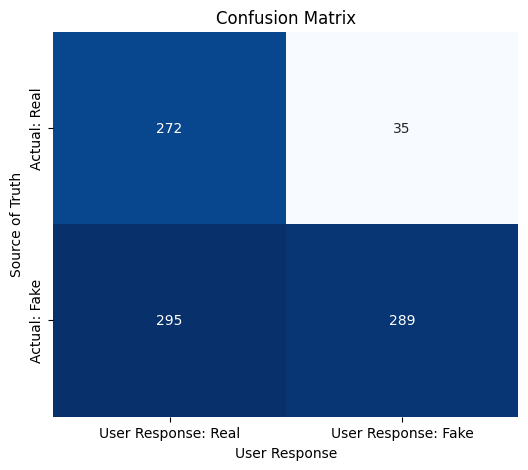

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6296296296296297  |
| 1 |         Precision (REAL)          | 0.47971781305114636 |
| 2 |   True Negative Accuracy (FAKE)   | 0.8919753086419753  |
| 3 |              Recall               | 0.8859934853420195  |
| 4 | True Negative Rate ( Recall Fake) | 0.4948630136986301  |
| 5 |        False Positive Rate        | 0.5051369863013698  |
| 6 |        False Negative Rate        | 0.11400651465798045 |
| 7 |            Error Rate             | 0.37037037037037035 |
| 8 |             F1 Score              | 0.6224256292906178  |
+---+-----------------------------------+---------------------+


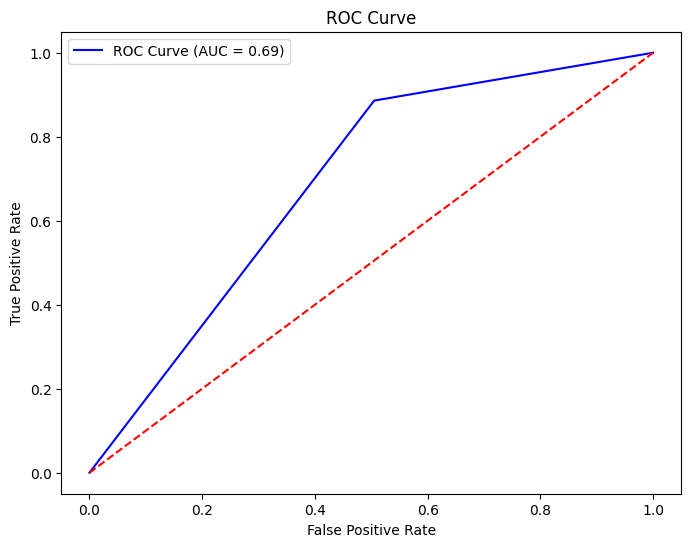

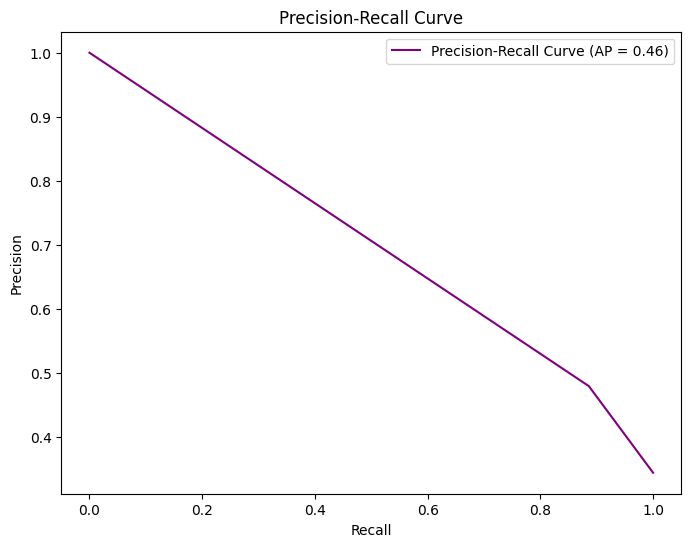

For branch Electrical Engineering



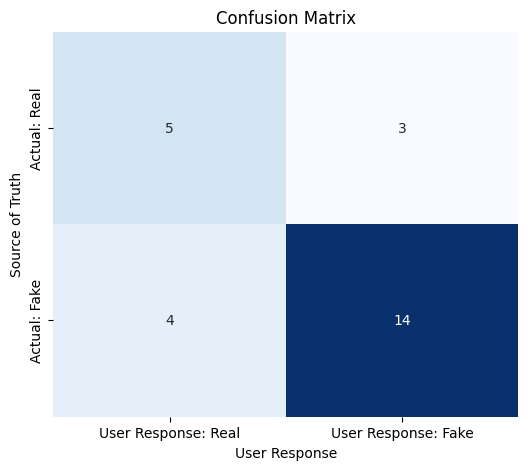

+---+-----------------------------------+--------------------+
|   |              Metric               |       Value        |
+---+-----------------------------------+--------------------+
| 0 |             Accuracy              | 0.7307692307692307 |
| 1 |         Precision (REAL)          | 0.5555555555555556 |
| 2 |   True Negative Accuracy (FAKE)   | 0.8235294117647058 |
| 3 |              Recall               |       0.625        |
| 4 | True Negative Rate ( Recall Fake) | 0.7777777777777778 |
| 5 |        False Positive Rate        | 0.2222222222222222 |
| 6 |        False Negative Rate        |       0.375        |
| 7 |            Error Rate             | 0.2692307692307692 |
| 8 |             F1 Score              | 0.5882352941176471 |
+---+-----------------------------------+--------------------+


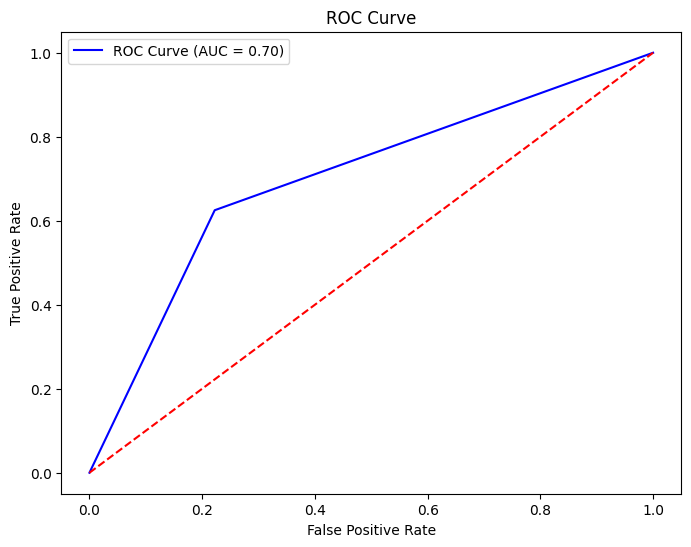

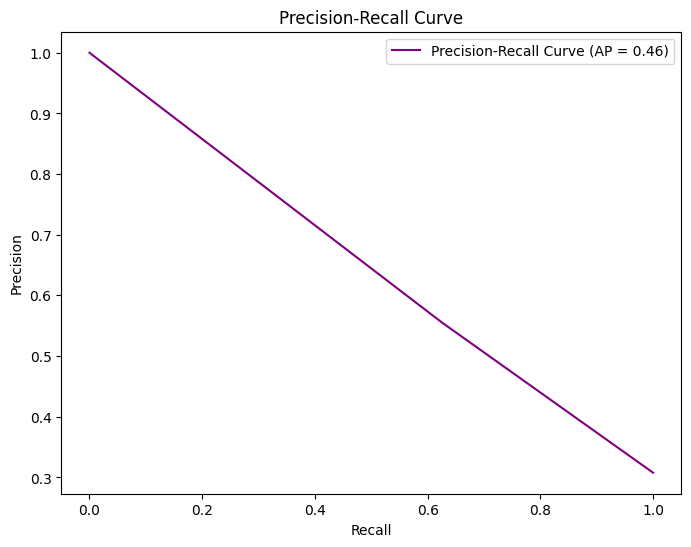

For branch Materials Science Programme



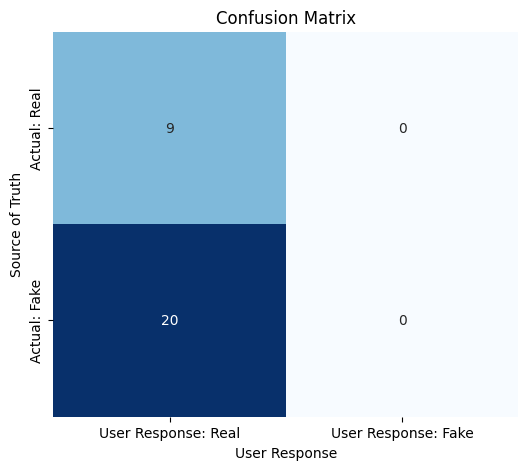

+---+-----------------------------------+--------------------+
|   |              Metric               |       Value        |
+---+-----------------------------------+--------------------+
| 0 |             Accuracy              | 0.3103448275862069 |
| 1 |         Precision (REAL)          | 0.3103448275862069 |
| 2 |   True Negative Accuracy (FAKE)   |        0.0         |
| 3 |              Recall               |        1.0         |
| 4 | True Negative Rate ( Recall Fake) |        0.0         |
| 5 |        False Positive Rate        |        1.0         |
| 6 |        False Negative Rate        |        0.0         |
| 7 |            Error Rate             | 0.6896551724137931 |
| 8 |             F1 Score              | 0.4736842105263158 |
+---+-----------------------------------+--------------------+


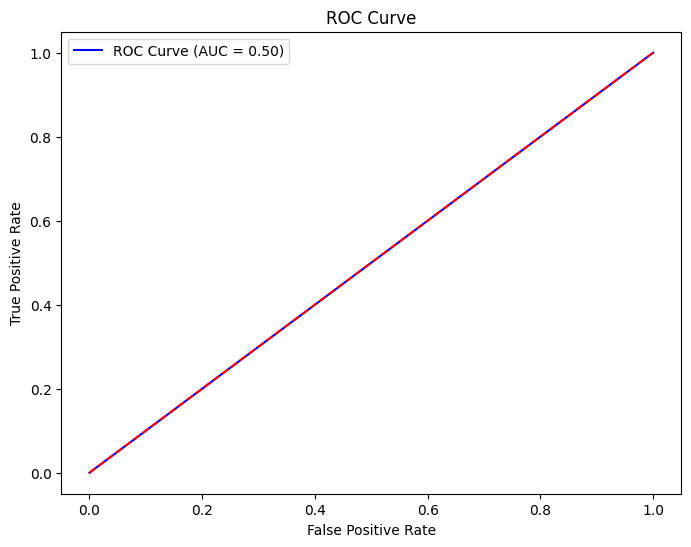

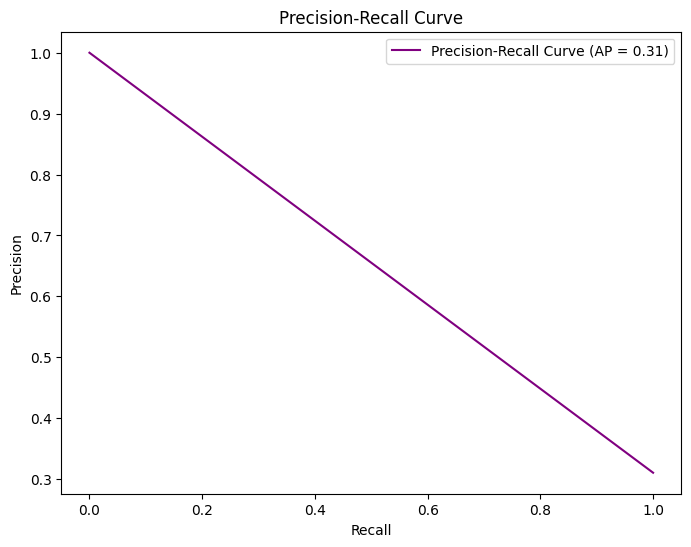

For branch Materials Science and Engineering



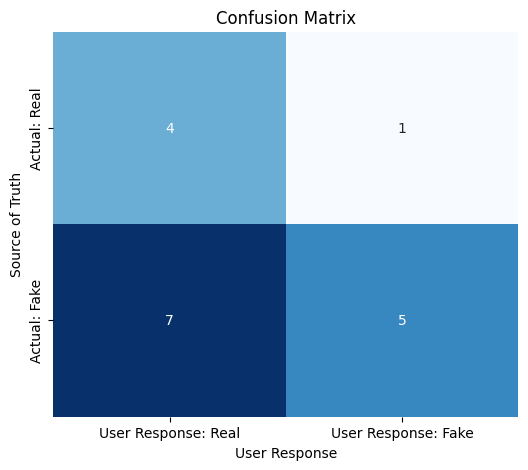

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.5294117647058824  |
| 1 |         Precision (REAL)          | 0.36363636363636365 |
| 2 |   True Negative Accuracy (FAKE)   | 0.8333333333333334  |
| 3 |              Recall               |         0.8         |
| 4 | True Negative Rate ( Recall Fake) | 0.4166666666666667  |
| 5 |        False Positive Rate        | 0.5833333333333334  |
| 6 |        False Negative Rate        |         0.2         |
| 7 |            Error Rate             | 0.47058823529411764 |
| 8 |             F1 Score              | 0.5000000000000001  |
+---+-----------------------------------+---------------------+


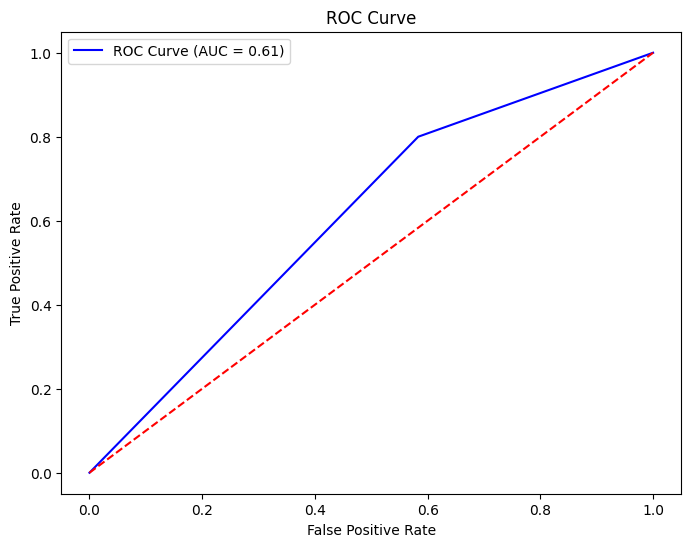

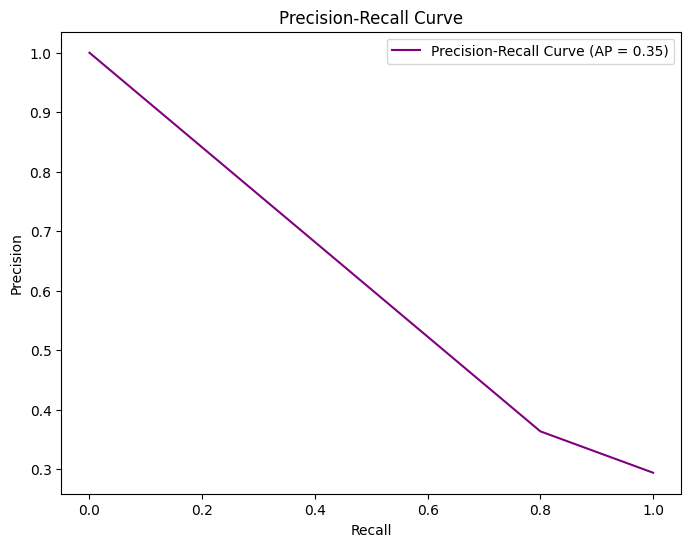

For branch Mechanical Engineering



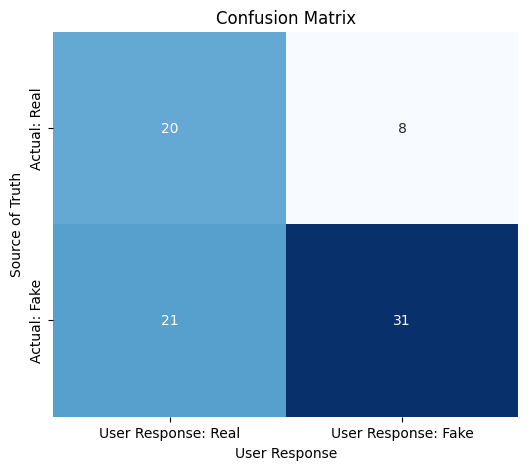

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              |       0.6375        |
| 1 |         Precision (REAL)          | 0.4878048780487805  |
| 2 |   True Negative Accuracy (FAKE)   | 0.7948717948717948  |
| 3 |              Recall               | 0.7142857142857143  |
| 4 | True Negative Rate ( Recall Fake) | 0.5961538461538461  |
| 5 |        False Positive Rate        | 0.40384615384615385 |
| 6 |        False Negative Rate        | 0.2857142857142857  |
| 7 |            Error Rate             |       0.3625        |
| 8 |             F1 Score              | 0.5797101449275363  |
+---+-----------------------------------+---------------------+


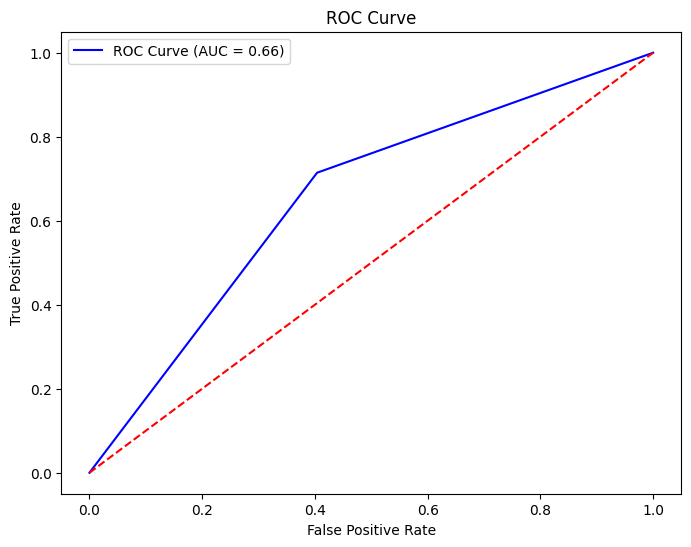

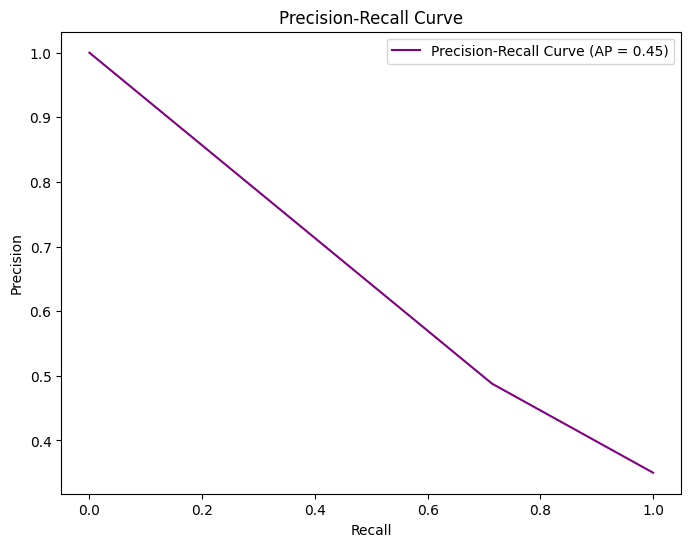

For branch Others



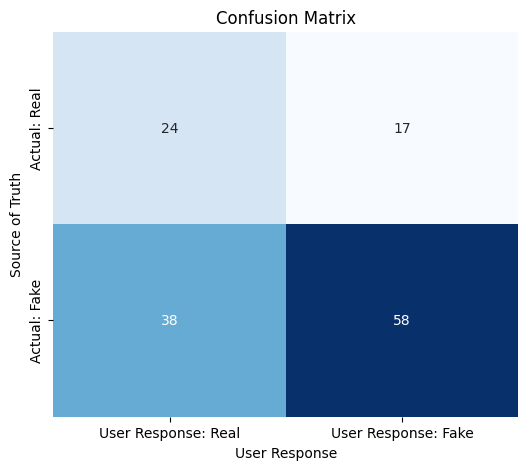

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.5985401459854015  |
| 1 |         Precision (REAL)          | 0.3870967741935484  |
| 2 |   True Negative Accuracy (FAKE)   | 0.7733333333333333  |
| 3 |              Recall               | 0.5853658536585366  |
| 4 | True Negative Rate ( Recall Fake) | 0.6041666666666666  |
| 5 |        False Positive Rate        | 0.3958333333333333  |
| 6 |        False Negative Rate        | 0.4146341463414634  |
| 7 |            Error Rate             | 0.40145985401459855 |
| 8 |             F1 Score              | 0.4660194174757281  |
+---+-----------------------------------+---------------------+


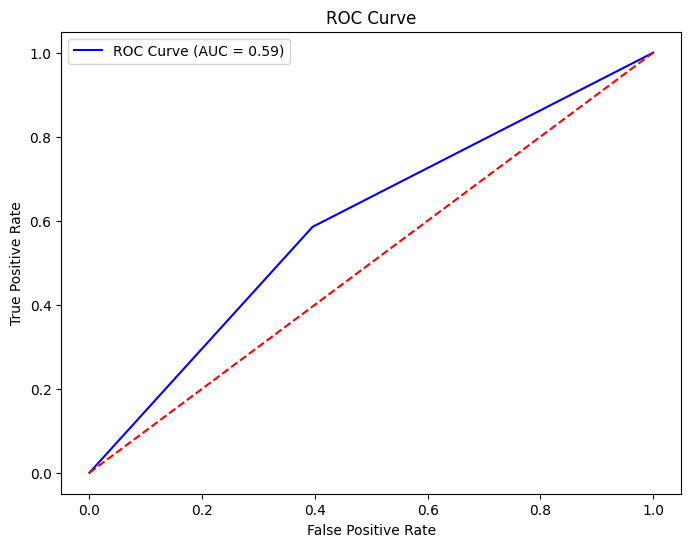

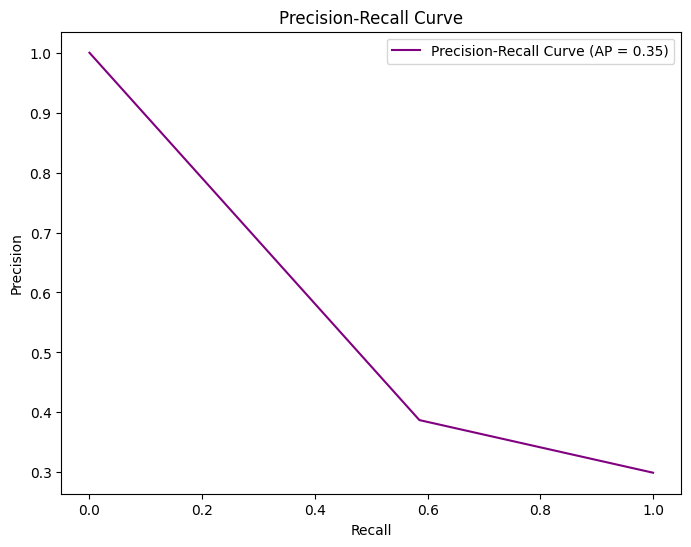

For branch Statistics



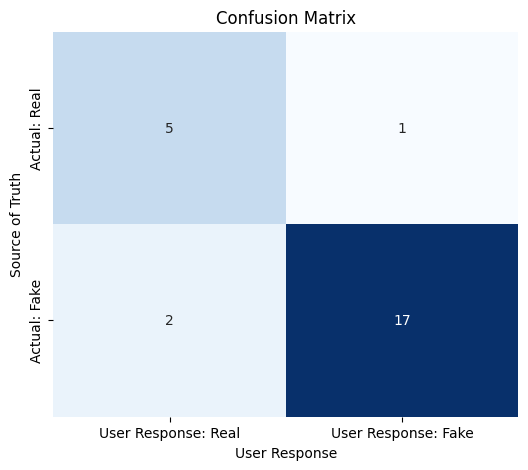

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              |        0.88         |
| 1 |         Precision (REAL)          | 0.7142857142857143  |
| 2 |   True Negative Accuracy (FAKE)   | 0.9444444444444444  |
| 3 |              Recall               | 0.8333333333333334  |
| 4 | True Negative Rate ( Recall Fake) | 0.8947368421052632  |
| 5 |        False Positive Rate        | 0.10526315789473684 |
| 6 |        False Negative Rate        | 0.16666666666666666 |
| 7 |            Error Rate             |        0.12         |
| 8 |             F1 Score              | 0.7692307692307692  |
+---+-----------------------------------+---------------------+


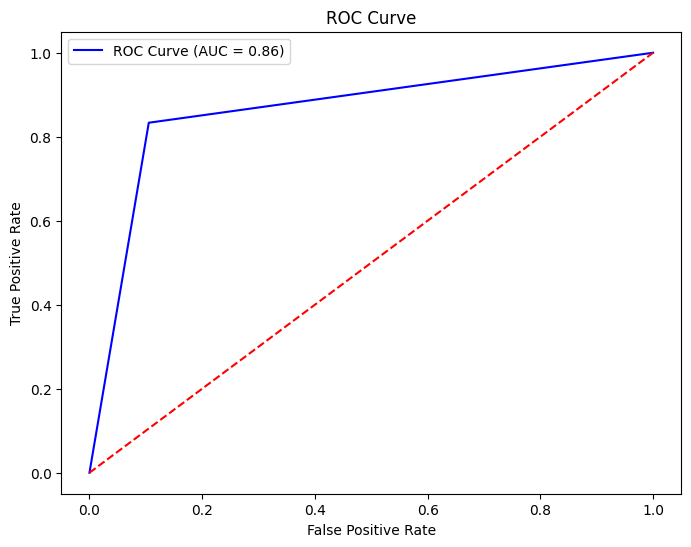

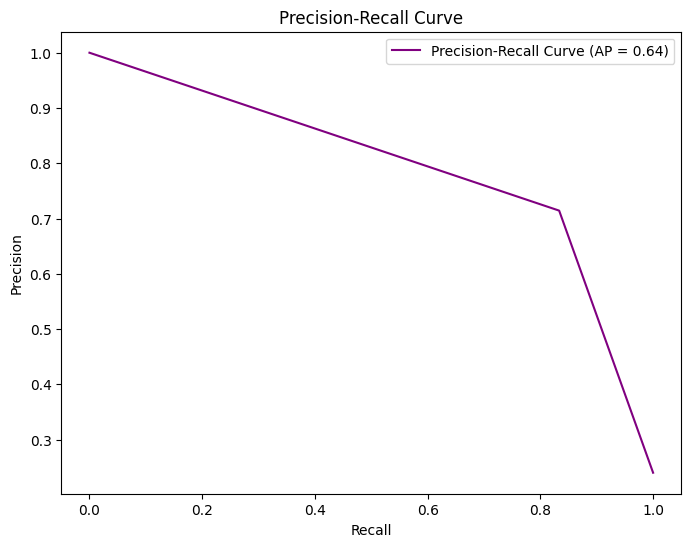

In [9]:
df_dept = dfd.df_user.groupby('department')
for i, j in df_dept:
    print(f'For branch {i}\n')            
    responses = dfd.user_responses[dfd.user_responses['user_id'].isin(j['user_id'])]    
    dfd.confusion_matrix_metrics(responses)

---

## Age Range Wise

For age_range 20-29



/var/folders/c_/gnwm993x4t7cq3tflg_9jq7w0000gn/T/ipykernel_31712/773810563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_range = dfd.df_user.groupby('age_range')


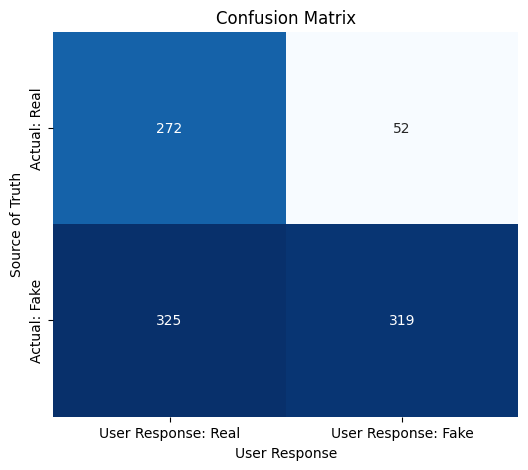

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6105371900826446  |
| 1 |         Precision (REAL)          | 0.4556113902847571  |
| 2 |   True Negative Accuracy (FAKE)   | 0.8598382749326146  |
| 3 |              Recall               | 0.8395061728395061  |
| 4 | True Negative Rate ( Recall Fake) | 0.4953416149068323  |
| 5 |        False Positive Rate        | 0.5046583850931677  |
| 6 |        False Negative Rate        | 0.16049382716049382 |
| 7 |            Error Rate             | 0.3894628099173554  |
| 8 |             F1 Score              | 0.5906623235613463  |
+---+-----------------------------------+---------------------+


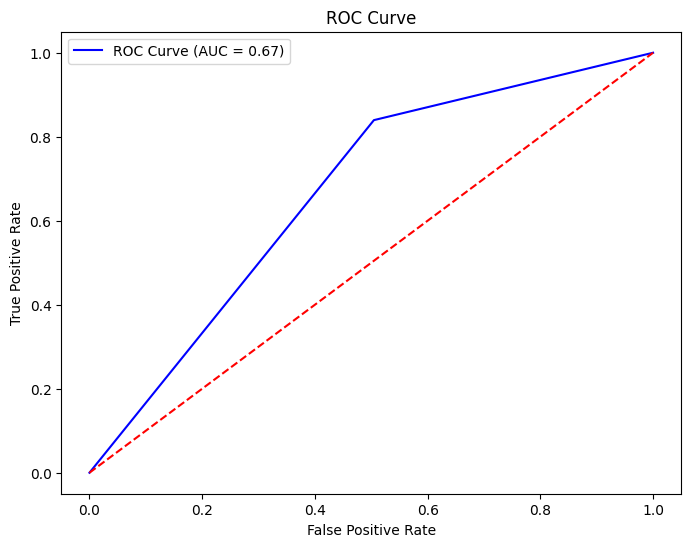

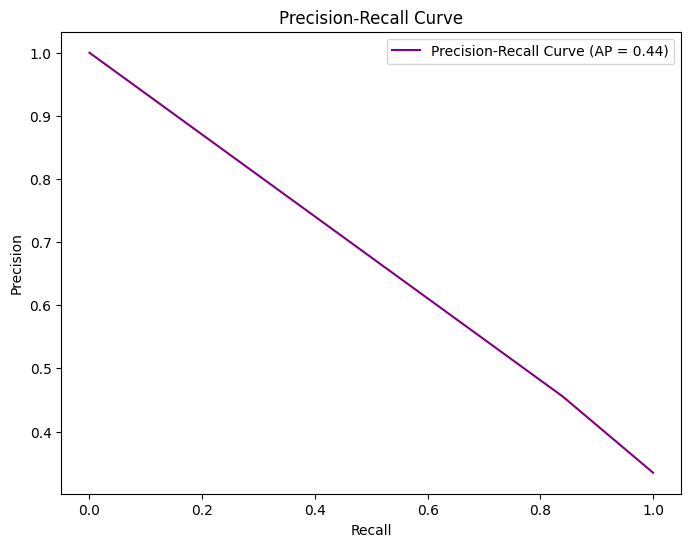

For age_range 30+



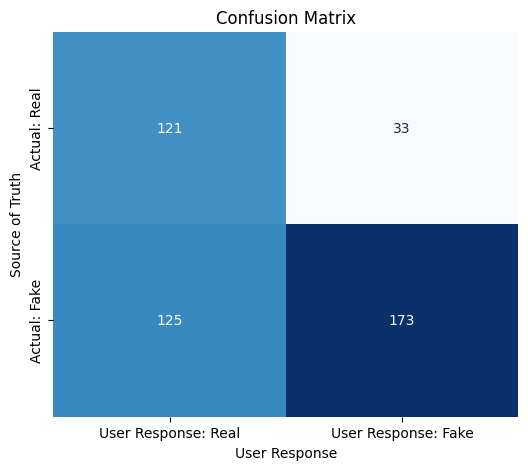

+---+-----------------------------------+---------------------+
|   |              Metric               |        Value        |
+---+-----------------------------------+---------------------+
| 0 |             Accuracy              | 0.6504424778761062  |
| 1 |         Precision (REAL)          |  0.491869918699187  |
| 2 |   True Negative Accuracy (FAKE)   | 0.8398058252427184  |
| 3 |              Recall               | 0.7857142857142857  |
| 4 | True Negative Rate ( Recall Fake) | 0.5805369127516778  |
| 5 |        False Positive Rate        | 0.41946308724832215 |
| 6 |        False Negative Rate        | 0.21428571428571427 |
| 7 |            Error Rate             | 0.3495575221238938  |
| 8 |             F1 Score              |        0.605        |
+---+-----------------------------------+---------------------+


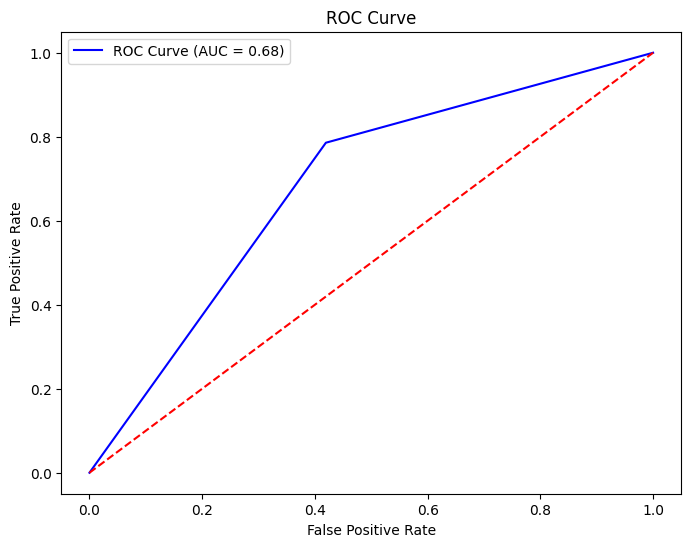

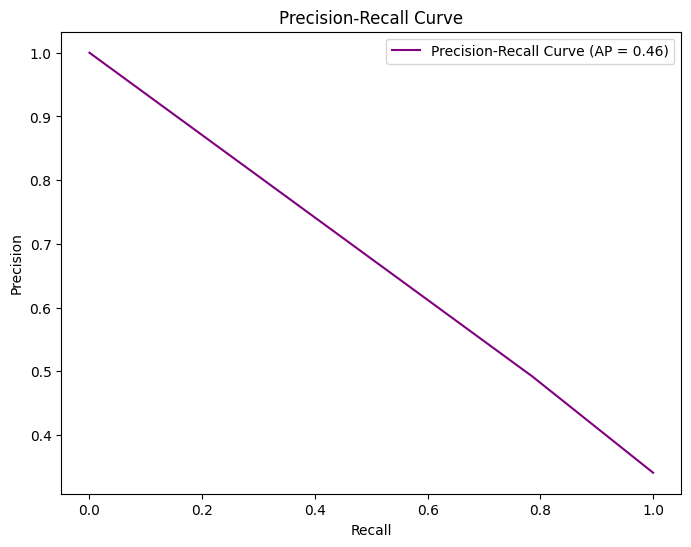

In [12]:
age_range = dfd.df_user.groupby('age_range')
for i, j in age_range:        
    if j.shape[0] > 0:
        print(f'For age_range {i}\n')    
        responses = dfd.user_responses[dfd.user_responses['user_id'].isin(j['user_id'])]                
        dfd.confusion_matrix_metrics(responses)

---

## Cosine Similarity

Number of responses: 6


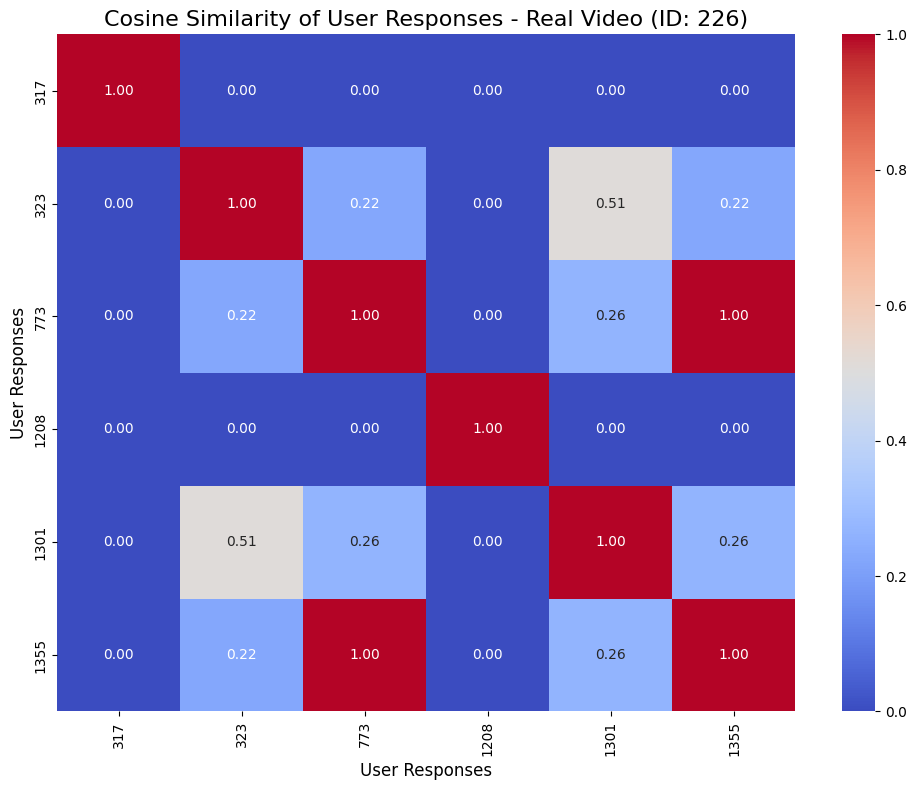

Number of responses: 7


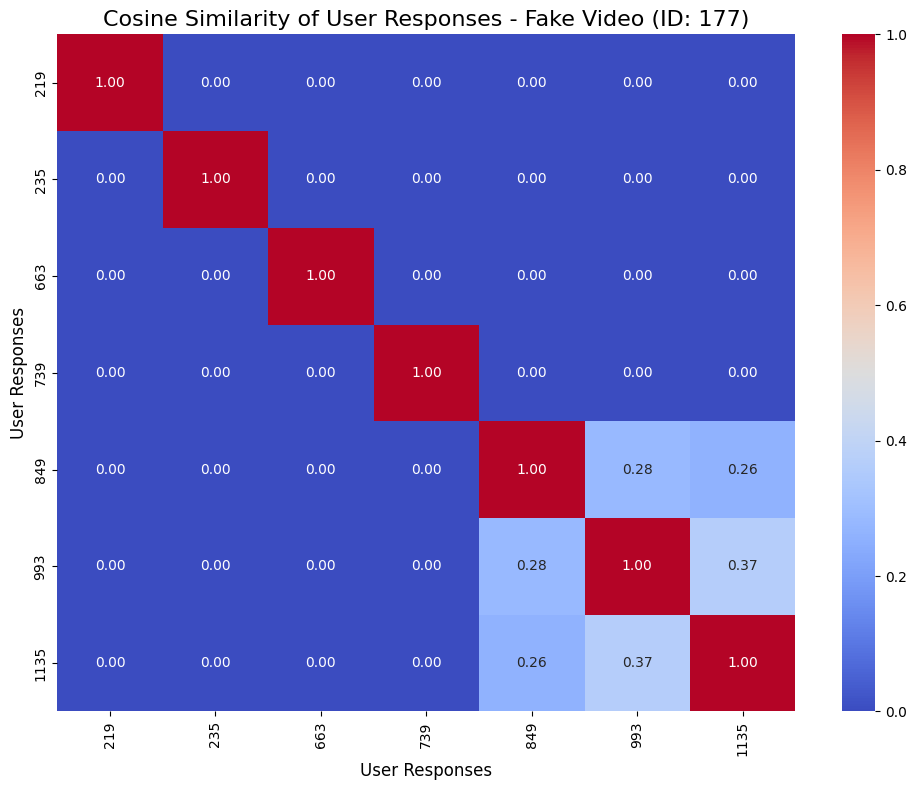

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def plot_cosine_similarity(responses, title):
    print(f"Number of responses: {len(responses)}")
    
    # Calculate TF-IDF matrix for the responses
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(responses)

    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Plot the cosine similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cosine_sim_matrix,
        annot=True,  # Add annotations
        fmt=".2f",  # Format for the annotation values
        cmap='coolwarm',
        xticklabels=responses.index if isinstance(responses, pd.Series) else None,
        yticklabels=responses.index if isinstance(responses, pd.Series) else None
    )
    plt.title(title, fontsize=16)
    plt.xlabel('User Responses', fontsize=12)
    plt.ylabel('User Responses', fontsize=12)
    plt.xticks(fontsize=10, rotation=90)  # Rotate x-axis labels for better visibility
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

response_counts = dfd.user_responses.groupby(['video_id', 'is_real']).size().reset_index(name='response_count')
most_responded_real = response_counts[(response_counts['is_real'] == True)].sort_values(by='response_count', ascending=False).iloc[0]['video_id']
most_responded_fake = response_counts[(response_counts['is_real'] == False)].sort_values(by='response_count', ascending=False).iloc[0]['video_id']

# Step 2: Extract user responses for the selected videos
real_video_responses = dfd.user_responses[dfd.user_responses['video_id'] == most_responded_real]['reason'].fillna('')
fake_video_responses = dfd.user_responses[dfd.user_responses['video_id'] == most_responded_fake]['reason'].fillna('')

# display(fake_video_responses)
# display(real_video_responses)
# Step 3: Plot cosine similarity for real and fake videos
plot_cosine_similarity(real_video_responses, title=f"Cosine Similarity of User Responses - Real Video (ID: {most_responded_real})")
plot_cosine_similarity(fake_video_responses, title=f"Cosine Similarity of User Responses - Fake Video (ID: {most_responded_fake})")

---

## Thematic Analysis

In [16]:
dfd.lda()

Topic 1:
movement | eyes | blinking | lighting | head | normal | shadows | right | consistent | flickering
Topic 2:
natural | voice | expressions | edges | real | body | person | movements | quite | standing
Topic 3:
lip | matching | sync | shadows | lighting | natural | mismatch | lack | expressions | background
Topic 4:
fake | expression | facial | doesn | edited | shadow | video | matches | person | action
Topic 5:
real | face | video | looks | expressions | smooth | issue | blurred | distorted | morphed


---

## TF-IDF

/var/folders/c_/gnwm993x4t7cq3tflg_9jq7w0000gn/T/ipykernel_22655/2381230376.py:226: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_score', y='word', data=real_unique_df.head(15), palette='Blues_d')
/var/folders/c_/gnwm993x4t7cq3tflg_9jq7w0000gn/T/ipykernel_22655/2381230376.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_score', y='word', data=fake_unique_df.head(15), palette='Reds_d')


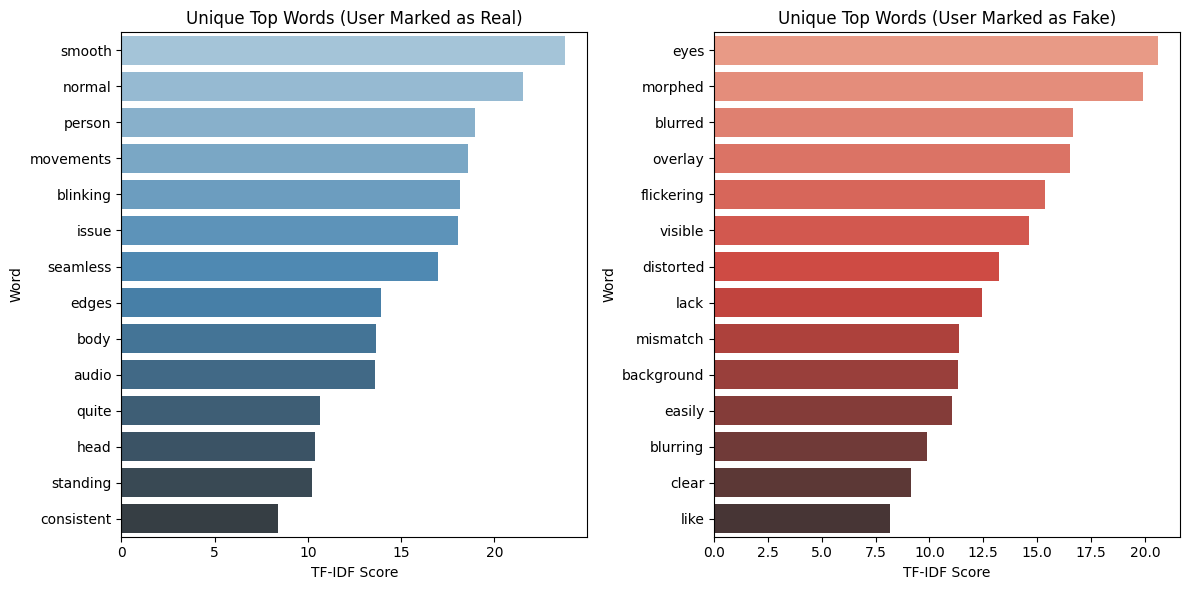

In [17]:
dfd.tf_df_show()

# For Real Videos

In [18]:
df_real = dfd.user_responses[dfd.user_responses['is_real'] == True]
df_merged_real = df_real.merge(dfd.df_video, on='video_id', how='left', suffixes=('_user', '_truth'))
df_merged_real['is_correct'] = df_merged_real['is_real_user'] == df_merged_real['is_real_truth']

print(df_real.shape)
df_true_correct = df_merged_real[df_merged_real['is_correct'] == True]
display(df_true_correct.shape)

print(f'% of correct = {((df_true_correct.shape[0])/df_real.shape[0])*100}')
df_true_incorrect = df_merged_real[df_merged_real['is_correct'] == False]

(843, 8)


(393, 15)

% of correct = 46.619217081850536


# For Fake Videos

In [19]:
df_false = dfd.user_responses[dfd.user_responses['is_real'] == False]

df_merged_fake = df_false.merge(dfd.df_video, on='video_id', how='left', suffixes=('_user', '_truth'))
df_merged_fake['is_correct'] = df_merged_fake['is_real_user'] == df_merged_fake['is_real_truth']

print(df_merged_fake.shape)
df_false_correct = df_merged_fake[df_merged_fake['is_correct'] == True]
display(df_false_correct.shape)

print(f'% of correct = {(df_false_correct.shape[0]/df_false.shape[0])*100}')
df_false_incorrect = df_merged_fake[df_merged_fake['is_correct'] == False]
print(df_false_incorrect.shape)

(577, 15)


(492, 15)

% of correct = 85.2686308492201
(85, 15)
